<center>
    <u>
        <font size=50>House Prices: <br><br>Advanced Regression Techniques</font>
    </u>
</center><br><br>

**<font size=5>Acknowledgements:</font>**

I would like to thank following people for their helpful open-surce Kaggle kernels and analysis on **House Prices: Advanced Regression Techniques** dataset and other people for asking and answering some principal questions about statistics, ML, and data in general:
* Alexandru Papiu  - [Regularized Linear Models](https://www.kaggle.com/apapiu/regularized-linear-models)
* Serigne - [Stacked Regressions : Top 4% on LeaderBoard](https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard)
* Luka Lončar - [Combo Set - The merge of train and test set](https://www.kaggle.com/questions-and-answers/40640)
* Oscar Takeshita - [What is considered to be leakage in imputation?](https://www.kaggle.com/c/titanic/discussion/37730)
* Jeff Hale - [Scale, Standardize, or Normalize with Scikit-Learn](https://towardsdatascience.com/scale-standardize-or-normalize-with-scikit-learn-6ccc7d176a02)
* Julien Cohen-Solal - [A study on Regression applied to the Ames dataset](https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset)
* Aarshay Jain - [Complete Machine Learning Guide to Parameter Tuning in Gradient Boosting (GBM) in Python](https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/)

# General

* **Data Type**: Tabular data
* **Problem Type**: Need to predict house prices - an **offline supervised regression** task
* **Performance Measure / Evaluation Metric**: *Root Mean Squared Logarithmic Error*

$$\text{RMSLE}(y, \hat{y}) = \sqrt{\frac{1}{n_\text{s}} \sum_{i=0}^{n_\text{s} - 1} (\ln (1 + y_i) - \ln (1 + \hat{y}_i) )^2},$$
$y_i$ - *true value* <br>
$\hat{y}_i$ - *prediction* <br>
$n_\text{s}$ - *number* of samples

* **Human expertice**: *Medium* - logical assumptions on data preprocessing are enough
* **Assumptions**:
    * There are **4** outliers in the training set that can be removed (based on data instructor recommendation [source](http://jse.amstat.org/v19n3/decock.pdf))
    * We can combine train and test sets for these preprocessing steps:
        * **Label encoding** (There might be classes not represented in either of the sets, thus making both sets aware of these possible classes)
        * **Imputation** (Taking median/average/most frequent values from all of the data)
        * **Standardization / Scaling** (Since actual test labels are not provided for Kaggle competitions this is not information leakage*)
    * Houses in the same neighborhood are simialar (taking the mean/median of the same neihborhood house features is a better estimate than of the whole dataset)
    * Features which calss imbalances are very high (99%) carry no useful information and can be **dropped**.
* **Miscellaneous**:
    * **Small** dataset - train, test sets **1500** observations and **80** features

## Imports

In [71]:
#general
import pandas as pd
import numpy as np
import os, re
import seaborn as sns
from scipy import stats
from scipy.stats import norm, skew
from scipy.special import boxcox1p
import math

# preprocessing
from sklearn.preprocessing import StandardScaler, \
    PolynomialFeatures, LabelEncoder, RobustScaler, MinMaxScaler, \
    MaxAbsScaler, PowerTransformer, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_selection import SelectKBest, f_regression, RFE

from category_encoders.target_encoder import TargetEncoder
from category_encoders.backward_difference import BackwardDifferenceEncoder
from category_encoders.helmert import HelmertEncoder
from category_encoders.leave_one_out import LeaveOneOutEncoder
from category_encoders.polynomial import PolynomialEncoder

# postprocessing
from sklearn.metrics import mean_squared_log_error, make_scorer, fbeta_score, \
    mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, \
    cross_val_score, KFold
from sklearn.feature_selection import SelectFromModel

# visualizations

import bokeh_plots as bp
import matplotlib.pyplot as plt
import seaborn as sns
import bokeh
from IPython.display import clear_output
from bokeh.plotting import figure, output_notebook, show
from bokeh.palettes import Category10
from bokeh.models import ColumnDataSource, HoverTool, Legend, NumeralTickFormatter
from bokeh.layouts import gridplot, row, column

# models
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, \
    BayesianRidge, SGDRegressor, LassoCV, LassoLarsIC
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import LinearSVR, SVR, NuSVR
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor, \
    GradientBoostingRegressor, RandomForestRegressor, VotingRegressor
import xgboost
import lightgbm
from category_encoders.target_encoder import TargetEncoder

#get rid of some of the warning sklearn and pandas through
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn

from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=RuntimeWarning)

**EDA Functions**

In [2]:
#plots boxplots if dataframe column is categorical
#and histogram if df feature is continuous
def eda_feature(df, feature, target, bins=50):
    '''Plots box plots or a hstogram of a feature based on if it is
    categorical or continuous-numeric type.
    
    Parameters
    ----------
    df : DataFrame
        DataFrame of the data.
    feature : str
        Feature column name in the df.
    target : str
        Target coumn name in the df.
    bins : int
        Number of bins to plot if feature is target.
    
    Returns
    -------
    None
    '''
    
    from IPython.display import clear_output
    import bokeh_plots as bp
    
    #clear the output field 
    clear_output()
    
    #based on the number of unique values it has
    #determine if feature is categorical or continuous
    n_uniques = len(df[feature].unique())
    if df[feature].dtype == 'O' or n_uniques <= 20:
        
        #print normalized value counts of the classes
        print('Class Distributions:\n{}'.format(df[feature].value_counts(normalize=True, dropna=False)))
        
        # plot box plots of the feature vs target
        bp.box(df=df, x=feature, y=target)
    else:
        
        #print the number of nan values
        print('{} NaN-s: {}/{}'.format(feature, df[feature].isna().sum(),
                                       len(df[feature])))
        
        #if feature is continuous plot a histogram
        bp.hist(df=df, feature=feature, bins=bins)

In [3]:
#generator function for categorizing features
def eda_features(df, target, bins=50):
    '''Inspecting and grouping features into discrete (input "d"), 
    continuous (input "c") and potentially features 
    to drop (nput "x") lists.
    
    Parameters
    ----------
    df : DataFrame
        DataFrame to be explored
    target : str
        Target column name in the df.
    bins : Number of bins to be shown when target is continuous.
    
    Returns
    -------
    discrete : list
        Categorical feature names.
    continuous : list
        Continuous feature names.
    drop: list
        Potential feature names to be dropped.
    '''
    
    from IPython.display import clear_output
    
    discretes = []
    continuous = []
    to_drop = []
    def wrapper():
        '''Wrapper function for automating feature 
        inspection and categorizaton.'''
        for feature in df:
            
            #if iteration/generation reaches target to break the loop
            if feature == target:
                clear_output()
                break
            
            eda_feature(df, feature, target, bins=bins)
            inp = input()
            if inp == 'd':
                yield discretes.append(feature)
            elif inp == 'c':
                yield continuous.append(feature)
            elif inp == 'x':
                yield to_drop.append(feature)
            else:
                break
                
    
    for gen in wrapper():
        gen
    return discretes, continuous, to_drop

## Loading Data

In [4]:
data_path = 'data/iowa_house_prices/'
train = pd.read_csv(data_path + 'train.csv', header=0)
test = pd.read_csv(data_path + 'test.csv', header=0)

print('Train set shape: {}'.format(train.shape))
print('Test set shape: {}'.format(test.shape))

Train set shape: (1460, 81)
Test set shape: (1459, 80)


## Removing Outliers
* As explained in the assumptions paragraph, we will remove 4 data points from the training since dataset instructor suggested it. To see why we do that, let's plot SalePrice vs GrLivArea where the outliers become evident
* It is suggetsed to remove all data points that have above grade square feet > 4000

In [5]:
#init in notebook bokeh plotting
output_notebook()

Loading BokehJS ...

In [6]:
#above ground living area vs sale price
bp.scatter(train, 'GrLivArea', 'SalePrice')

In [7]:
#removing datapoints where 'GrLivArea' > 4000 square feet
train_outl_removed = train[train.GrLivArea < 4000]

print('Train with outliers shape: {}'.format(train.shape))
print('Train without outliers shape: {}'.format(train_outl_removed.shape))

Train with outliers shape: (1460, 81)
Train without outliers shape: (1456, 81)


## Target
* Extracting target 'SalePrice' values : y

In [8]:
#target values
y = train_outl_removed.SalePrice.values

1. Examine SalePrice distribution
2. Estimate if <code>y</code> is normally distributed
3. Also plot Quantile-Quantile plot to visually see if the target is normally distributed
4. Target is normally distributed if:<br>
    a) the target distribution is Gaussian on distribution plot<br>
    b) the actual quantiles would reside on the fitted line on QQ plot

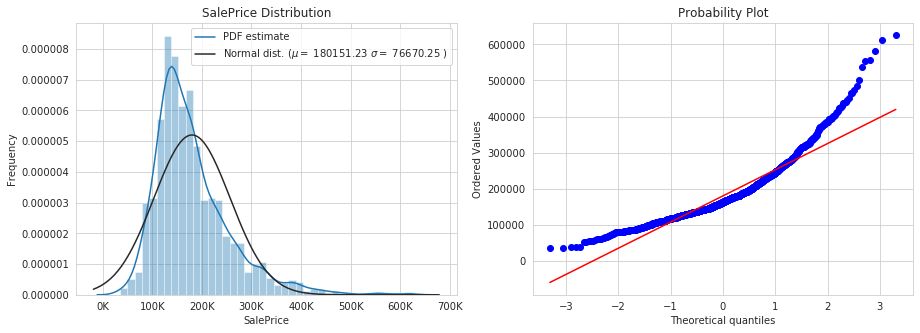

In [9]:
sns.set_style('whitegrid')

#plot target distribution
plt.figure(figsize=(15,5))
plt.subplot(121)
p = sns.distplot(y, fit=norm, kde=True, kde_kws={'label':'pdf'})

# Get the fitted parameters used by the function
mu, sigma = norm.fit(train_outl_removed['SalePrice'])
p.legend(['PDF estimate','Normal dist. ($\mu=$ {:.2f} $\sigma=$ {:.2f} )'\
            .format(mu, sigma)], loc='best')
plt.xlabel('SalePrice')
plt.ylabel('Frequency')
plt.title('SalePrice Distribution')

xtick_labels = ["{:.0f}".format(tick/1000)+'K' for tick in p.get_xticks()]
p.set_xticklabels(xtick_labels)

#quantile-quantile plot to visually detect skewnes
plt.subplot(122)
res = stats.probplot(y, plot=plt)

plt.show()

The target variable <code>y</code> is right skewed. As (linear) models love normally distributed data , we need to transform this variable and make it more normally distributed.

In [10]:
#log+1 transformed target values
ln_y = np.log1p(y)
ln_y.shape

(1456,)

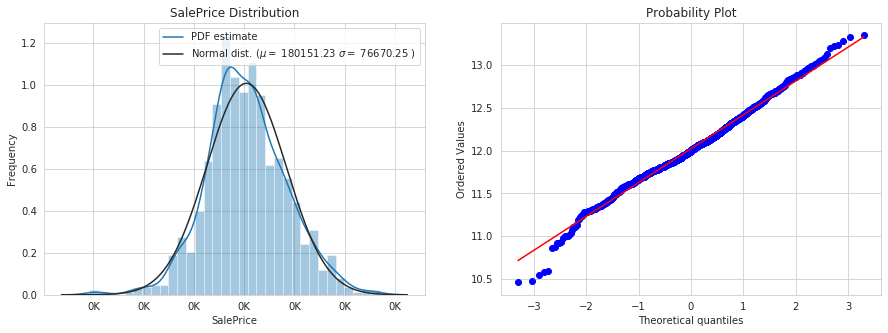

In [11]:
#plot transformed target distribution
plt.figure(figsize=(15,5))
plt.subplot(121)
p = sns.distplot(ln_y, fit=norm, kde=True, kde_kws={'label':'pdf'})

# Get the fitted parameters used by the function
mu, sigma = norm.fit(train_outl_removed['SalePrice'])
p.legend(['PDF estimate','Normal dist. ($\mu=$ {:.2f} $\sigma=$ {:.2f} )'\
            .format(mu, sigma)], loc='best')
plt.xlabel('SalePrice')
plt.ylabel('Frequency')
plt.title('SalePrice Distribution')

xtick_labels = ["{:.0f}".format(tick/1000)+'K' for tick in p.get_xticks()]
p.set_xticklabels(xtick_labels)

#quantile-quantile plot to visually detect skewnes
plt.subplot(122)
res = stats.probplot(ln_y, plot=plt)

plt.show()

<code>log(y)+1</code> transforming target for:
* RMSLE evaluation (so we only need to use RMSE)
* trasnform target to more Gaussian distribution

# EDA

## Categorizing Features
* With a help of pre-witten functions we examine feature:
    * Distributions if it is continuous - histograms
    * Class distributions if categorical - box plots
    * Divide features into 3 lists:
        * Discrete features
        * Continuous/Numeric Features
        * Features to (potentially) drop
    * Get ideas for data **imputing** and **feature engineering**

In [12]:
#initial examining and appending features into 3
#categories: discrete-, continuous-, and potentially dropping features
#discrete_f, continuous_f, drop_f = eda_features(train_outl_removed, 'SalePrice')

In [13]:
cat_features = [
    'MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 
    'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 
    'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'RoofStyle', 
    'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 
    'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 
    'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 
    'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 
    'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'SaleType', 
    'SaleCondition', 'MiscFeature', 'RoofMatl', 'YrSold', 'MoSold']

num_features = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 
                'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 
                'GrLivArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 
                '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'GarageCars',
                'BedroomAbvGr', 'KitchenAbvGr', 'HalfBath', 'FullBath', 'TotRmsAbvGrd',
                'Fireplaces', 'BsmtHalfBath', 'BsmtFullBath', 'YearBuilt', 'YearRemodAdd', 
                'GarageYrBlt']

drop_features = ['Id', 'Utilities']

* <code>Id</code> - Is not used for data analysis but as a index later.
* <code>Utilities</code> - dropped, since it effectively holds only one class.

In [14]:
#make sure all features are categorized
print('Total features before categorization: {}'.format(train.drop('SalePrice', axis='columns').shape[1]))
print('Total features categorized: {}'.format(len(cat_features + num_features + drop_features)))

Total features before categorization: 80
Total features categorized: 80


# Preprocessing

**<font size=4>Combine Train & Test</font>**<br>

We want to combine **train** and **test** sets for data preprocessing for:<br>
* **Fixing Typos** - There can be typos in both of the train and test datasets.
* **Imputation** - Taking median/average/most frequent values from all of the data.
* **Categorical data encoding** - There might be classes not represented in either of the sets, thus making both sets aware of these possible classes.
* **Standardization / Scaling** - Capture total range of the dataset. **<font color='red'>NB!</font>** In real world this step may or may not be considered an information leakage between the train and the test sets.

In [15]:
#capture test set first id value which
#we use as a cutoff value when we separate 
cutoff_id = test.Id[0]
print('Cutoff Id: {}'.format(cutoff_id))

Cutoff Id: 1461


* Concating train & test sets into a single dataframe - <code>data_raw</code>
* <code>verify_integrity</code> checks for duplicate index values

In [16]:
data_raw = pd.concat([train_outl_removed.drop(['SalePrice', 'Utilities'], axis='columns'), 
                  test.drop('Utilities', axis='columns')], axis='rows', sort=False).\
                  set_index('Id', verify_integrity=True)

print('data_raw shape:', data_raw.shape)

data_raw shape: (2915, 78)


**Copy of the raw combined data for the next chapters**

In [17]:
data = data_raw.copy()

## Fixing Typos
Through EDA we can detect possible typos in the data.

In [18]:
data[['GarageYrBlt']].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
GarageYrBlt,2756.0,1978.079826,25.576507,1895.0,1960.0,1979.0,2002.0,2207.0


We can see a typo in <code>GarageYrBlt</code> - it's maximum value is 2207 but that year has not been recorded yet. Most probably it is 2007. Let's investigate related year features for year 2207.

In [19]:
data[data.GarageYrBlt == 2207][['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrSold']]

,YearBuilt,YearRemodAdd,GarageYrBlt,YrSold
Id,,,,
2593,2006,2007,2207.0,2007


Garage was definitely built in 2007 together with the remodelling. We also see by the <code>Id</code> that the typo was in the <code>test</code> set. Let's replace the 2207 with 2007.

In [20]:
data.loc[2593,'GarageYrBlt'] = 2007

print('GarageYrBlt summary stats after fixing the typo.')
data[['GarageYrBlt']].describe().transpose()

GarageYrBlt summary stats after fixing the typo.


,count,mean,std,min,25%,50%,75%,max
GarageYrBlt,2756.0,1978.007257,25.207825,1895.0,1960.0,1979.0,2002.0,2010.0


## Imputation
* Giving a "best guess" for missing values.
* Before imputing mssing values with popular feature statistics like mean, median or mode, <code>NaN</code> may refere to 0, 'None' or something else based on the metadata.
* Some fetaure <code>NaN</code> values are imputed based on or are a combination of other feature summary statistics.
* Impute numeric and categorical dtypes separately.

### Numeric

**Missing values**

In [21]:
#missing values of numric features
num_nans = data[num_features].isna().sum().to_frame('nan_count').\
    sort_values('nan_count', ascending=False)
num_nans[num_nans.nan_count > 0].transpose()

,LotFrontage,GarageYrBlt,MasVnrArea,BsmtFullBath,BsmtHalfBath,BsmtUnfSF,TotalBsmtSF,BsmtFinSF2,GarageCars,GarageArea,BsmtFinSF1
nan_count,486,159,23,2,2,1,1,1,1,1,1


In [22]:
#no missing values
num_clean = num_nans[num_nans.nan_count == 0]
print(num_clean.index.to_list())

['YearRemodAdd', 'YearBuilt', 'Fireplaces', 'TotRmsAbvGrd', 'FullBath', 'HalfBath', 'KitchenAbvGr', 'BedroomAbvGr', 'ScreenPorch', 'MiscVal', 'PoolArea', 'LotArea', 'EnclosedPorch', 'OpenPorchSF', 'WoodDeckSF', 'GrLivArea', 'LowQualFinSF', '2ndFlrSF', '1stFlrSF', '3SsnPorch']


**<code>LotFrontage</code>**<br>
Following the idea from **Serigne** [Stacked Regressions : Top 4% on LeaderBoard](https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard), a good estimate for the **NaN** values in <code>LotFrontage</code> would be the **median**<code>LotFrontage</code> of a given <code>Neighborhood</code> assuming the linear feet of street connected to property in a given neighborhood is similar. 
* This is good approach and definitely performs better than just using the overall **mean** of the <code>LotFrontage</code>.
* **<font color='green'>However</font>**, if we fill in the missing values by median <code>LotFrontage</code> and lot configuration <code>LotConfig</code> of a given <code>Neighborhood</code> we would be even more precise about imputing the missing values.
* As an aftermath, including <code>LotConfig</code> to the equation improved the public leaderboard error score by at least **<font color='green'>0.3%</font>**, which is significant improvement in terms of data imputation for a single feature. The imputation impact of <code>LotFrontage</code> can be explained with the large fraction of missing values in the data.
* By imputing <code>LotFrontage</code> more precisely will positively affect the features we are going to engineere based on it.

In [23]:
print("LotFrontage NaN-s: {}".format(data.LotFrontage.isna().sum()))

#check if there are any missing values 
#for the Neighborhood and LotConfig features
print("Neighborhood NaN-s: {}".format(data['Neighborhood'].isna().sum()))
print("LotConfig NaN-s: {}".format(data['LotConfig'].isna().sum()))

LotFrontage NaN-s: 486
Neighborhood NaN-s: 0
LotConfig NaN-s: 0


In [24]:
#impute the NaN-s
data.loc[:,'LotFrontage'] = data.groupby(['Neighborhood', 'LotConfig'])['LotFrontage'] \
    .transform(lambda x: x.fillna(x.median()))

#confirm missing values
print("LotFrontage NaN-s: {}".format(data.LotFrontage.isna().sum()))

LotFrontage NaN-s: 4


* We have 4 cases where missing value couldn't be imputed.
* Let's investigate this manually by determining the index, Neighborhood and LotConfig values of these 4 cases.

In [25]:
data[data.LotFrontage.isna()][['Neighborhood', 'LotConfig']]

,Neighborhood,LotConfig
Id,,
1942,Gilbert,FR3
1958,NWAmes,FR3
2635,NWAmes,FR3
2678,Gilbert,FR3


* The missing values stayed in since there were no summary statistic about these particular lot configurations (**'FR3'**).
* In order to impute these values we need to find the best **alternative** lot configuration for the **'FR3'**.
* Let's visualize the distribution of <code>LotFrontage</code> by each <code>Neighborhood</code> and its <code>LotConfig</code>.

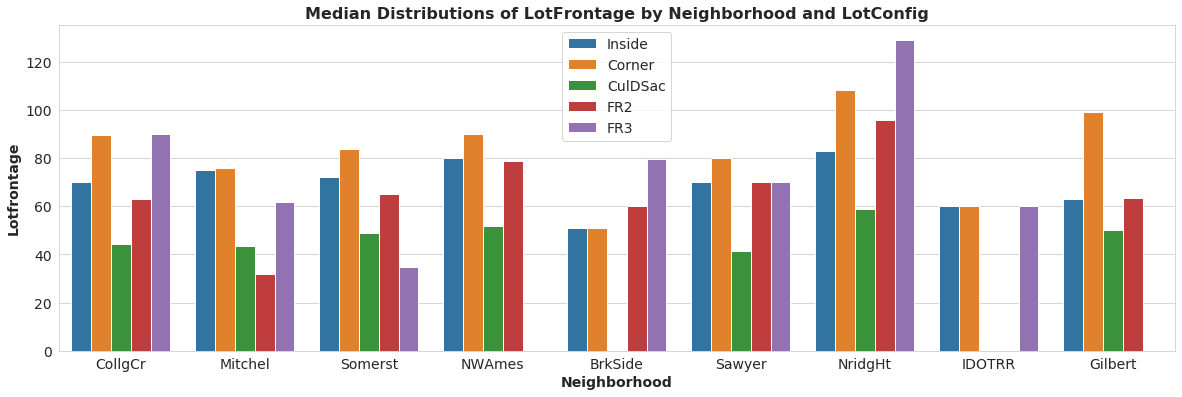

In [26]:
#unique Neighborhoods where FR3 is represented
fr3s = data[data.LotConfig == 'FR3'].Neighborhood.unique()

#capture data only of these unique neighborhoods
fr3_data = data[data.Neighborhood.isin(fr3s)]

#plot the median distributions
plt.figure(figsize=(20,6))
ax = sns.barplot(x='Neighborhood', y='LotFrontage', hue='LotConfig', data=fr3_data, 
                 ci=None, estimator=np.median)

plt.title('Median Distributions of LotFrontage by Neighborhood and LotConfig', weight='bold', fontsize=16)
plt.legend(loc='upper center', prop={'size':14})
plt.xlabel('Neighborhood', fontsize=14, weight='bold')
plt.ylabel('Lotfrontage', fontsize=14, weight='bold')
ax.tick_params(axis='both', which='major', labelsize=14)

plt.show()

* **FR3** stands for 'frontage (street) on 3 sides of the property'. 
* Qualitatively, it would makes sense it to be larger than Inside, CulDSac and FR2 frontage.
* On the plot we can see that it is the case for most of the neighborhoods. 
* On average, FR3 seems to be similar to the **Corner** lot - thus we use that as an **alternative** to 'FR3'.

In [27]:
#capture LotFrontage values grouped by Neighborhood and LotConfig
groups = data.groupby(['Neighborhood', 'LotConfig'])['LotFrontage']

#capture median 'Corner' lot values in two neighborhoods
gilbert_median = groups.get_group(('Gilbert', 'Corner')).median()
nwames_median = groups.get_group(('NWAmes', 'Corner')).median()

#impute the missing 'FR3' values by median 'Corner' lot value
data.loc[[1942,2678], 'LotFrontage'] = gilbert_median
data.loc[[1958,2635], 'LotFrontage'] = nwames_median

#check missing values again
print("LotFrontage NaN-s: {}".format(data.LotFrontage.isna().sum()))

LotFrontage NaN-s: 0


**<code>GarageYrBlt</code>**<br>

In [28]:
#check if GarageYrBlt is NaN due to no Grage.
data[data['GarageYrBlt'].isna()][['GarageType', 'GarageQual', 'GarageCond']].isna().all()

GarageType    False
GarageQual     True
GarageCond     True
dtype: bool

We can assume that <code>NaN</code> in <code>GarageYrBuilt</code> corresponds to no garage. Thus we can fill missing values with 0. Quoting **[Hendrik's](https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard)** comment:<br>
<br>
<i>"It is the best way to go with 0. For the computer it doesn't matter if the information is accurate but the influance of the information is important. Therefore all of these algorithms will be able to categorize all of the houses without a garage as the garage "is built in year 0""</i>

In [29]:
#impute with 0
data['GarageYrBlt'] = data.GarageYrBlt.fillna(0)

#check
print('GarageYrBlt NaN-s: {}'.format(data['GarageYrBlt'].isna().sum()))

GarageYrBlt NaN-s: 0


**<code>MasVnrArea</code>**<br>
Check corresponding <code>MasVnrType</code> values.

In [30]:
#inspect the NaN-s of MasVnrArea for MasVnrType
data[data['MasVnrArea'].isna()]['MasVnrType'].value_counts(dropna=False)

NaN    23
Name: MasVnrType, dtype: int64

In [31]:
#MasVnrArea can be converted to 0 since these houses have no masonry indicated
data['MasVnrArea'] = data.MasVnrArea.fillna(0)

**<code>Basement & Garage features</code>**<br>
Check if NaN-s in <code>BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF</code> correspond to No basement in <code>BsmtQual</code> feature.

In [32]:
bsmt_f = ['BsmtHalfBath', 'BsmtFullBath', 'BsmtFinSF1', 'BsmtFinSF2', 
          'TotalBsmtSF', 'BsmtUnfSF']
data[data['BsmtFinSF1'].isna()][bsmt_f]

,BsmtHalfBath,BsmtFullBath,BsmtFinSF1,BsmtFinSF2,TotalBsmtSF,BsmtUnfSF
Id,,,,,,
2121,NaN,NaN,NaN,NaN,NaN,NaN


Check if missing values in garage features correspond to no Garage.

In [33]:
garage_f = ['GarageArea', 'GarageCars']
data[data['GarageArea'].isna()][garage_f + ['GarageQual']]

,GarageArea,GarageCars,GarageQual
Id,,,
2577,NaN,NaN,NaN


In [34]:
#impute basement and garage NaN-s with 0-s
data.loc[:,bsmt_f + garage_f] = data.loc[:,bsmt_f + garage_f].fillna(0)

**All numeric NaN-s**

In [35]:
print('Total numeric NaN-s: {}'.format(data[num_features].isna().sum().sum()))

Total numeric NaN-s: 0


### Categorical

**Missing values**

In [36]:
cat_nans = data[cat_features].isna().sum().to_frame('nan_count').\
    sort_values('nan_count', ascending=False)

#print top 11 features by NaN count
cat_nans[cat_nans.nan_count > 0].head(11).transpose()

,PoolQC,MiscFeature,Alley,Fence,FireplaceQu,GarageCond,GarageFinish,GarageQual,GarageType,BsmtExposure,BsmtCond
nan_count,2907,2810,2717,2345,1420,159,159,159,157,82,82


In [37]:
# sklearn & DF compatible imputer transformer
class DFImputer(BaseEstimator, TransformerMixin):
    """Imputes DF missing values based on fill_value.
    
    Parameters
    ----------
    cols : list of str
        List of DF column names to be imputed. If None, all the columns are imputed.
        this is useful if the transformer is used in a ColumnTransformer pipeline. If
        cols are specified, only these columns in the DF are transformed and others are
        passed through.
    fill_value : str / int / float
        Strategy or value to be filled. Available strategies are ['mean','median','most_frequent'].
        If anything else is passed, the argument is interpreted to be a constant.
        
    Returns
    -------
    df[cols] : DataFrame
        Returns DF with imputed columns if cols=None.
    df : DataFrame
        Returns full df (imputed and not imputed features), if cols are specified.
    """
    def __init__(self, cols=None, fill_value='mean'):
        self.fill_value = fill_value
        self.cols = cols
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        if self.cols == None:
            if self.fill_value == 'mean':
                return X.fillna(X.mean())
            elif self.fill_value == 'median':
                return X.fillna(X.median())
            elif self.fill_value == 'most_frequent':
                return X.fillna(X.mode().iloc[0])
            else:
                return X.fillna(self.fill_value)
        else:
            if self.fill_value == 'mean':
                X[self.cols] = X[self.cols].fillna(X[self.cols].mean())
            elif self.fill_value == 'median':
                X[self.cols] = X[self.cols].fillna(X[self.cols].median())
            elif self.fill_value == 'most_frequent':
                X[self.cols] = X[self.cols].fillna(X[self.cols].mode().iloc[0])
            else:
                X[self.cols] = X[self.cols].fillna(self.fill_value)
            return X

In [38]:
#impute missing values to most common value
to_most_common = ['MSZoning', 'Exterior1st', 'Exterior2nd', 'Electrical', 
                  'KitchenQual', 'Functional', 'SaleType']

data[to_most_common] = DFImputer(fill_value='most_frequent').fit_transform(X=data[to_most_common])


#impute missing values to 'None' - as a separate class
to_none = ['Alley', 'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
           'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 'GarageType',
           'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence',
           'MiscFeature']

data[to_none] = DFImputer(fill_value='None').fit_transform(data[to_none])

print('Cat NaN-s: {}'.format(data[cat_features].isna().sum().sum()))

Cat NaN-s: 0


**Total Missing Values Check**

In [39]:
print('All NaN-s: {}'.format(data.isna().sum().sum()))

All NaN-s: 0


## Feature Engineering
* Creating **new** features (out of the old).
* This can be done through:
    * Binning
    * Grouping
    * Splitting
    * Transforming

**Train & Test Separation**<br>
* Separate imputed data and add the target feature for EDA.

In [40]:
#separated train data with no target
train_imped_y = data.loc[:cutoff_id-1,:]

#add target feature to the train data
train_imped_y.loc[:,'SalePrice'] = y

In [41]:
#as a checkpoint init copy of the imputed DF
data_fe = data.copy()

**Functions to examine feature correlation with the target**

In [42]:
#feature 1st and potential 2nd order correlation with the target 
def feat_corr(feature, target, df, figsize=(7,5)):
    """Scatter plot with 1st and/or 2nd Order polynomial fit and
    95% confidence interval.
    
    Parameters
    ----------
    feature : str
        Feature name in the DF.
    target : str
        Target name in the DF.
    df : DataFrame
    figsize : tuple of len 2
        Tuple of figure dimensions. Default (7,5).
    
    Retruns
    -------
    None"""
    
    r_value1 = stats.pearsonr(df[feature], df[target]) #1st order Pearson corr coef
    r_value2 = stats.pearsonr(df[feature]**2, df[target]) #2nd order Pearson corr coef
    
    if abs(r_value2[0]) > abs(r_value1[0]): 
    # plot y(x) with regression line and uncertainty area
        fig = plt.figure(figsize=figsize)
        sns.regplot(x=feature, y=target, data=df, line_kws={'color':'red','label':'order 1'})
        sns.regplot(x=feature, y=target, data=df, order=2, label='order 2', color='green', scatter=None)
        plt.title('{} r_1={:.2f}, r_2={:.2f}'.format(feature, r_value1[0], r_value2[0]), fontsize=14, weight='bold')
        plt.xlabel(feature, fontsize=14)
        plt.ylabel(target, fontsize=14)
        plt.legend()
        plt.show()
    else:
        plt.figure(figsize=figsize)
        ax=sns.regplot(x=feature, y=target, data=df, line_kws={'color':'red','label':'order 1'})
        ax.set_title('{} r_1={:.2f}'.format(feature, r_value1[0]), fontsize=14, weight='bold')
        plt.xlabel(feature, fontsize=14)
        plt.ylabel(target, fontsize=14)
        plt.legend()
        plt.show()

In [43]:
def feats_squared_corr(features, target, df):  
    """Scatter plot of feature and target if 2nd Order poly fit R^2 is greater
    than 1st Order poly fit R^2.
    
    Parameters
    ----------
    features : str | list of str
        Feature name or list of feature names.
    target : str
        Target name in the df.
    df : DataFrame
    
    Returns
    -------
    None
    """ 
    
    if type(features) == str:
        r_value1 = stats.pearsonr(df[features], df[target]) #1st order Pearson corr coef
        r_value2 = stats.pearsonr(df[features]**2, df[target]) #2nd order Pearson corr coef
        
        if abs(r_value2[0]) > abs(r_value1[0]):
            plt.figure(figsize=(7,5))
            sns.regplot(x=features, y=target, data=df, line_kws={'color':'red','label':'1st Order'})
            sns.regplot(x=features, y=target, data=df, order=2, label='2nd Order', color='green', scatter=None)
            plt.title('{} r_1={:.2f}, r_2={:.2f}'.format(features, r_value1[0], r_value2[0]), 
                      fontsize=14, weight='bold')
            plt.xlabel(features, fontsize=14)
            plt.ylabel(target, fontsize=14)
            plt.legend()
            plt.show()
        else:
            print('2nd Order correlation did not exceed 1st Order.')
    else:
        
        squares = []
        for f in features:
            r1 = stats.pearsonr(df[f], df[target])
            r2 = stats.pearsonr(df[f]**2, df[target])
            if abs(r2[0]) > abs(r1[0]):
                squares.append((f,r1[0],r2[0]))

        if len(squares) == 0:
            return '2nd Order correlation did not exceed 1st Order for all features.'
        
        elif len(squares) == 1:
            plt.figure(figsize=(7,5))
            sns.regplot(x=features, y=target, data=df, line_kws={'color':'red','label':'1st Order'})
            sns.regplot(x=features, y=target, data=df, order=2, label='2nd Order', color='green', scatter=None)
            plt.title('{} r_1={:.2f}, r_2={:.2f}'.format(features, r_value1[0], r_value2[0]), 
                      fontsize=14, weight='bold')
            plt.xlabel(features, fontsize=14)
            plt.ylabel(target, fontsize=14)
            plt.legend()
        
        else:
            rows = math.ceil(len(squares) / 3)
            fig, axes = plt.subplots(rows,3, figsize=(20,rows*7), 
                                     subplot_kw={'xticks':(), 'yticks':()})

            for i, (ax,tpl) in enumerate(zip(axes.ravel(), squares)):
                if i >= len(squares):
                    break
                else:
                    ax.set_title('{} r_1={:.2f}, r_2={:.2f}'.format(tpl[0], tpl[1], tpl[2]), 
                                 fontsize=12, weight='bold')
                    ax.set_xlabel(tpl[0], fontsize=14)
                    ax.set_ylabel(target, fontsize=14)
                    sns.regplot(x=tpl[0], y=target, data=df, line_kws={'color':'red','label':'1st Order'}, ax=ax)
                    try:
                        sns.regplot(x=tpl[0], y=target, data=df, order=2, label='2nd Order', 
                                    color='green', scatter=None, ax=ax)
                    except ValueError:
                        pass
                    ax.legend()
            for ax in axes.ravel()[len(squares):]:
                ax.set_visible(False)
        plt.show()

### Numeric
* I give a more detailed explanation about the features I came up myself.
* Most of the engineered features are self-evident and do not need further explanation.
* I tested the impact of each new feature through public leaderboard score.

**<code>AreaFrontageRatio</code>**<br>
$$\text{AreaFrontageRatio}\,\,[F]=\frac{\text{LotArea}\,\,[F^2]}{\text{LotFrontage}\,\,[F]}$$<br>
* Ratio of the total surface area to total linear feet of street connected to the property. 
* Technically it is not a ratio but rather a proportionality between the two.
* <u>Initial motivation</u>: I interpreted the engineered feature as lot depth by assuming <code>LotFrontage</code> to be only on one side of the lot and each lot can be approximated to have a shape of a rectangle. Since the dimension of the <code>AreaFrontageRatio</code> is in **feet** the initial explanation was satisfactory. 
* Later I realized that the classes in <code>LotConfig</code> do not allow to interpret the new feature as lot depth since in general a lot can have <code>LotFrontage</code> on up to 3 sides of the lot and the former assumptions weren't applicable for finding the lot depth. I therefore interpreted it as a ratio.
* I also tried to capture the interaction via <code>LotArea</code> and <code>LotFrontage</code> product but it did not improve the score.
* **Public Score RMSLE Improvement:** **<font color='green'>-0.0092</font>**.

In [44]:
#lot area-frontage ratio
data_fe.loc[:,'AreaFrontageRatio'] = data_fe.LotArea / data_fe.LotFrontage

**<code>AreaLivRatio</code>**
$$\text{AreaLivRatio} = \frac{\text{LotaArea}\,\,[F^2]}{\text{GarageArea}\,\,[F^2] + \text{HouseArea}\,\,[F^2]}$$
* Total lot area and "used area" ratio. This is true ratio since it is dimensionless.
* We estimate house area on the lot to be equal with <code>1stFlrSF</code>.
* Porch & deck areas I consider to be recreational and not included in the used area.
* <u>Initial motivation</u>: Capture the yard/recreational area of the lot: <code>YardArea = LotArea - 1stFlrSF - GarageArea</code>. It didn't improve the public leaderboard score thus I tried to apply the ratio approach, which works.
* **Public Score RMSLE Improvement:** **<font color='green'>-0.0009</font>**.

In [45]:
#lot area and used area ratio
data_fe.loc[:,'AreaLivRatio'] = data_fe.LotArea / (data_fe.GarageArea + data_fe['1stFlrSF'])

**<code>StoneArea</code>**
* Stone type masonry veneer area.
* Missing values are 0, since these houses have no stone masonry.
* **Public Score RMSLE Improvement:** **<font color='green'>-0.0016</font>**.

In [46]:
#stone type masonry area
data_fe.loc[:,'StoneArea'] = data_fe[data_fe.MasVnrType == 'Stone']['MasVnrArea']
data_fe.loc[:,'StoneArea'] = data_fe['StoneArea'].fillna(0)

**<code>GLQBsmtArea</code>**
* Total good living quarters basement area.
* Either from <code>BsmtFinSF1, BsmtFinType1</code> combination, from <code>BsmtFinSF2, BsmtFinType2</code> combination or both.
* **Public Score RMSLE Improvement:** **<font color='green'>-0.0007</font>**.

In [47]:
#Good Living Quarters type basement area
def bsmt_fintype_area(row, value=None):
    if row['BsmtFinType1'] == value and row['BsmtFinType2'] != value:
        return row['BsmtFinSF1']
    elif row['BsmtFinType2'] == value and row['BsmtFinType1'] != value:
        return row['BsmtFinSF2']
    elif row['BsmtFinType1'] == value and row['BsmtFinType2'] == value:
        return row['BsmtFinSF1'] + row['BsmtFinSF2']
    else:
        return 0.0

data_fe.loc[:, 'GLQBsmtArea'] = data_fe.apply(bsmt_fintype_area, value='GLQ', axis='columns')

The rest of the features are self explanatory. All of them can be found in most of the popular kernels/notebooks.

In [48]:
#total SF of the house
data_fe.loc[:,'TotalSF'] = data_fe['TotalBsmtSF'] + data_fe['GrLivArea']

#total porch & deck area
porches = ['ScreenPorch','WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch']
data_fe.loc[:, 'TotalPorchSF'] = data_fe[porches].sum(axis='columns')

#age of the house
data_fe.loc[:, 'HouseAge'] = data_fe['YrSold'] - data_fe['YearRemodAdd']

#total number of rooms above grade including bathrooms
data_fe.loc[:,'TotalRoomsAboveGrade'] = data_fe['TotRmsAbvGrd'] + data_fe['FullBath'] + \
                                      data_fe['HalfBath'] / 2

#total number of bathrooms in the house
data_fe.loc[:, 'TotalBath'] = data_fe['BsmtFullBath'] + data_fe['BsmtHalfBath'] / 2 + \
                            data_fe['FullBath'] + data_fe['HalfBath'] / 2

#overall score
data_fe.loc[:, 'OverallScore'] = data_fe.OverallQual + data_fe.OverallCond

In [49]:
#capture all numeric features
nums = num_features + ['StoneArea', 'TotalSF', 'TotalPorchSF', 'AreaFrontageRatio', 
                       'AreaLivRatio', 'GLQBsmtArea', 'HouseAge', 'TotalRoomsAboveGrade',
                       'TotalBath', 'OverallScore']

In [50]:
#add target feaure to the engineered train set
train_fe_num = data_fe.loc[:cutoff_id-1,:]
train_fe_num['SalePrice'] = ln_y

**Squared Features**<br>
* Using our prewritten function <code>feats_squared_corr</code> we plot all numeric features only if the 2nd Order fit gives higher $R^2$ than the 1st Order.
* For saving the space I'll show three most promising features.

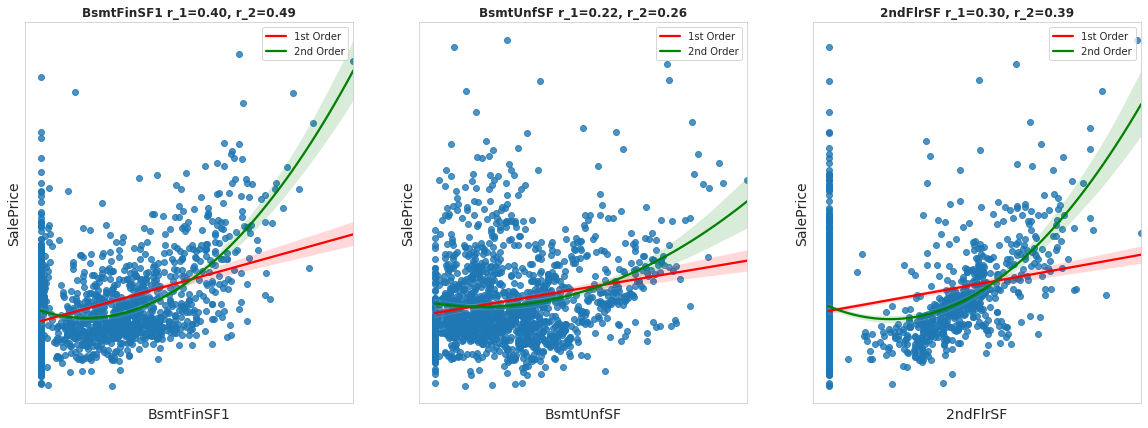

In [51]:
feats_squared_corr(['BsmtFinSF1', 'BsmtUnfSF', '2ndFlrSF'], 'SalePrice', train_imped_y)

* I tried to individually add each squared feature to our model.
* PL error score increasied for all of them.
* This is a suprising finding to me since the Pearson correlation coefficient is better for 2nd order fit.

### Ordinal
* Categorical features which classes can be ordered in some way.
* Here we init the mapping dictionary to later encode the classes into ordered integers.

In [52]:
#we used eda_features() function for determining ordinal features
ordinals = ['LotShape', 'LandSlope', 'OverallQual', 'OverallCond', 'ExterQual', 'ExterCond',
            'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1','BsmtFinType2', 'HeatingQC', 
            'KitchenQual', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive']

**<code>OverallCondition</code>**
* Weighing <code>Condition1</code> and <code>Condition2</code> classes with numeric values and then adding them together.
* Classes weights:
    * Negative: -1
    * Normal: 0.5
    * Positive: 1
* The weights were assigned using common sense. I tried 0 and 0.5 for the "Norm" class. The error score was lower when Norm == 0.5.
* The error score also improved when I didn't settle with the actual weights but the ordinal encoding of the weigths.

In [53]:
#overall condition
scores = {'Artery':-1, 'Feedr':-1, 'RRNn':-1, 'RRAn':-1, 'RRNe':-1, 
          'RRAe':-1, 'PosN':1, 'PosA':1, 'Norm':0.5} #value conversions

data_fe.loc[:,'OverallCondition'] = [scores[c1] + scores[c2] \
                                  for c1,c2 in zip(data_fe.Condition1, data_fe.Condition2)]

In [54]:
#add OverallCondition to ordinals
ords = ordinals + ['OverallCondition']

In [55]:
#mapping dictionary for the 
ordinals_mappings = [
    {'cols':['LotShape'], 'map':{'IR3':0,'IR2':1,'IR1':2,'Reg':3}},
    {'cols':['LandSlope'], 'map':{'Sev':0,'Mod':1,'Gtl':2}},
    {'cols':['ExterQual','ExterCond','HeatingQC','KitchenQual'], 'map':{'Po':0,'Fa':1,'TA':2,'Gd':3,'Ex':4}},
    {'cols':['BsmtQual','BsmtCond', 'FireplaceQu', 'GarageQual', 'GarageCond'], 
         'map':{'Po':0,'None':1,'Fa':2,'TA':3,'Gd':4,'Ex':5}},
    {'cols':['BsmtExposure'], 'map':{'None':0,'No':1,'Mn':2,'Av':3,'Gd':4}},
    {'cols':['BsmtFinType1','BsmtFinType2'], 'map':{'None':0,'Unf':1,'LwQ':2,
                                                    'Rec':3,'BLQ':4,'ALQ':5,'GLQ':6}},
    {'cols':['GarageFinish'], 'map':{'None':0,'Unf':1,'RFn':2,'Fin':3}},
    {'cols':['PavedDrive'], 'map':{'N':0,'P':1,'Y':2}},
    {'cols':['OverallCondition'], 'map':{-2:0, -0.5:1, 0:2, 1:3, 1.5:4, 2:5}}
]

### Nominal
* Categorical features that don't have a meaningful order between the classes in my mind. One could argue with that!

In [56]:
#nominal features
nominals = list(set(cat_features).difference(ordinals))

#house built equal remod or not
data_fe.loc[:,'BuiltEqualRemod'] = data_fe.YearBuilt == data_fe.YearRemodAdd
data_fe.loc[:,'BuiltEqualRemod'] = data_fe['BuiltEqualRemod'].astype('int64')

#downsample: 
data_fe.loc[:,'HasAlley'] = data_fe['Alley'].apply(lambda x: 0 if x == 'None' else 1)
data_fe.loc[:,'HasPool'] = data_fe['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
data_fe.loc[:,'Has2ndFlr'] = data_fe['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
data_fe.loc[:,'HasGarage'] = data_fe['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
data_fe.loc[:,'HasBsmt'] = data_fe['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
data_fe.loc[:,'HasFireplace'] = data_fe['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

**<code>Neighborhood</code>**<br>
* Downsample the <code>Neighborhood</code> by average <code>SalePrice</code>. **<font color='red'>CITATION!!!</font>**

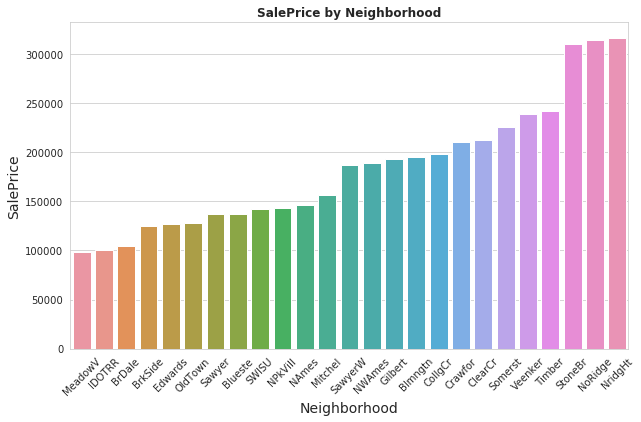

In [57]:
#groupby neighborhood and aggregate mean price
neighborhood_grouped = train_imped_y.groupby('Neighborhood').SalePrice.mean().\
    to_frame().sort_values('SalePrice').reset_index()

#plot the result
plt.figure(figsize=(10,6))
sns.barplot('Neighborhood', 'SalePrice', data=neighborhood_grouped)
plt.xticks(rotation=45)
plt.title('SalePrice by Neighborhood', fontweight='bold')
plt.xlabel('Neighborhood', fontsize=14)
plt.ylabel('SalePrice', fontsize=14)
plt.show()

#downsample: similar neighborhoods
neighborhood_mapping = {0:['MeadowV','IDOTRR','BrDale'],
                        1:['BrkSide','Edwards','OldTown','Sawyer','Blueste',
                           'SWISU','NPkVill','NAmes','Mitchel'],
                        2:['SawyerW','NWAmes','Gilbert','Blmngtn','CollgCr'],
                        3:['Crawfor','ClearCr', 'Somerst', 'Veenker', 'Timber'],
                        4:['StoneBr', 'NoRidge', 'NridgHt']}

#mapping function for neighborhood
def group_neighborhood(x):
    for k,v in neighborhood_mapping.items():
        if x in v:
            return int(k)

#map group numbers to Neighborhood
data_fe.loc[:,'NeighborhoodGrouped'] = data_fe.Neighborhood.apply(group_neighborhood)

In [58]:
noms = nominals + ['BuiltEqualRemod', 'HasAlley','HasPool','Has2ndFlr',
                   'HasGarage', 'HasBsmt', 'HasFireplace', 'NeighborhoodGrouped']

### Interactions
* I'm mainly looking interactions between the numeric features.
* Also include ordinal fetaures, which we need to encode before creating interactions. 
* Leave out nominals, since we 'dummy' encode them later on. 
* I use sklearn's <code>PolynomialFeatures</code> inside our custom sklearn trasnformer to create all possible 1st order feature interactions.
* Rank the results by pearson $R^2$ coefficient and try including some of them into the model.
* **<font color='red'>Better Way determining good interactions!!!</font>**

In [59]:
# create interaction features
class FeatureInteractions(BaseEstimator, TransformerMixin):
    """Generate all unique DataFrame 1st order feature interactions.
    
    Parameters
    ----------
    interaction_names : list of str
        List of interaction names. If Dataframe columns are ['A','B','C'], posssible 
        interaction names are: ['A_B', 'A_C', 'B_C'].
    
    Returns
    -------
    interaction_df : DataFrame
        DataFrame of interactions.
    """
    def __init__(self, interaction_names=None):
        self.interaction_names = interaction_names
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):    
        imped_df = X[X.columns].fillna(X[X.columns].mean())
        
        # generate all possible interaction names
        names = [col0+'_'+col1 for i,col0 in enumerate(imped_df) 
             for col1 in imped_df.columns[i+1:]]
        n_interactions = len(names) # determine number of interactions
        
        # generate numeric interactions
        interactions = PolynomialFeatures(degree=2, interaction_only=True) \
            .fit_transform(imped_df)[:,-n_interactions:]
        
        all_inters_df = pd.DataFrame(data=interactions, columns=names)
        
        if self.interaction_names is None:
                return all_inters_df
        else:
            return all_inters_df[self.interaction_names]
        
#ordinal feature encoder
class DFOrdinalsEncoder(BaseEstimator, TransformerMixin):
    """Encodes categorical features as ordinal based on mapping.
        
        Parameters
        ----------
        mapping_dicts : list of dicts
            List of dictionaries in a form of [{'cols':['col1','coln'],'map':{'None':0,a:1,b:2}}].
            'cols' key points to a list of column names whcih mappings, original to encoded label, 
            are the same."""
    def __init__(self, mapping_dicts):
        self.mapping_dicts = mapping_dicts
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X_ = X.copy()
        for col in X_.columns:
            for dict_ in self.mapping_dicts:
                if col in dict_['cols']:
                    X_[col] = X_[col].map(dict_['map'])
                    break
        return X_

In [60]:
#trasnform ordinals
data_fe_orded = DFOrdinalsEncoder(ordinals_mappings).fit_transform(data_fe)

#capture train data only
train_fe_orded = data_fe_orded.loc[:cutoff_id-1,nums+ords]
train_fe_orded.loc[:,'SalePrice'] = y

**$R^2$ Before Interactions**

In [61]:
#pairwise correlation of columns DF
corrs_df = train_fe_orded.corr()

#sort correlations by target feature
corrs_df.sort_values(['SalePrice'], axis=0, ascending=False, inplace=True)
corrs_df[corrs_df['SalePrice'] > 0.5]['SalePrice'].round(2).to_frame().transpose()

,SalePrice,TotalSF,OverallQual,GrLivArea,ExterQual,KitchenQual,GarageCars,TotalBsmtSF,GarageArea,TotalBath,...,1stFlrSF,TotalRoomsAboveGrade,OverallScore,FullBath,GarageFinish,TotRmsAbvGrd,GLQBsmtArea,YearBuilt,FireplaceQu,YearRemodAdd
SalePrice,1.0,0.82,0.8,0.72,0.69,0.67,0.65,0.65,0.64,0.64,...,0.63,0.6,0.6,0.56,0.56,0.54,0.54,0.54,0.53,0.52


**$R^2$ After Interactions**

In [62]:
#create feature interactions df
interacs_df = FeatureInteractions().fit_transform(data_fe_orded.loc[:cutoff_id-1,nums+ords])
interacs_df['SalePrice'] = y #add target 

#correlation df of interactions df
corrs_inter_df = interacs_df.corr()
corrs_inter_df.sort_values(['SalePrice'], axis=0, ascending=False, inplace=True)

#top 10 feature interactions by R^2
corrs_inter_df['SalePrice'].head(10).round(2).to_frame()

,SalePrice
SalePrice,1.00
TotalSF_OverallQual,0.91
TotalSF_ExterQual,0.89
TotalSF_KitchenQual,0.89
TotalSF_BsmtQual,0.88
TotalSF_OverallScore,0.88
GrLivArea_OverallQual,0.86
GrLivArea_ExterQual,0.85
GrLivArea_BsmtQual,0.85
GrLivArea_KitchenQual,0.85


**<code>TotalSF_OverallScore</code>**<br>
* $R^2$(TotalSF) = 0.82 $\quad\quad$ $R^2$(OverallScore)=0.6 $\quad\quad \longrightarrow\quad$ $R^2$(TotalSF_OverallScore) = **0.88**
* **Public Score RMSLE: <font color='green'>-0.0028</font>**.

In [63]:
#overall score & totalsf interaction
data_fe.loc[:, 'TotalSF_OverallScore'] = data_fe.OverallScore * data_fe.TotalSF

#add feature to numerics
nums.append('TotalSF_OverallScore')

**<font size=10 color='red'>Experimental!</font>**

**<code>TotalSF_OverallQual</code>**
\begin{align*}
    R_{TotalSF}^2&=0.82 \\
    R_{OverallScore}^2&=0.82\\
    R_{TotalSF\_OverallScore}^2&=0.88
\end{align*}

* **Public Score RMSLE: <font color='green'>-0.0003</font>**.

In [60]:
#selected features
interac_feats = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
                 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
                 'GrLivArea', 'GarageArea', 'StoneArea', 'TotalSF', 'TotalPorchSF',
                 'AreaFrontageRatio', 'AreaLivRatio', 'GLQBsmtArea', 'HouseAge']

#produce selected feature interactions
f_interacs = FeatureInteractions().fit_transform(data_fe.loc[:cutoff_id-1,interac_feats])
f_interacs['SalePrice'] = ln_y #add target 

#correlation df of interactions
corrs = f_interacs.corr()
corrs.sort_values(['SalePrice'], axis=0, ascending=False, inplace=True)
corrs[corrs['SalePrice'] > 0.75]['SalePrice'].round(2)

SalePrice                1.00
GarageArea_TotalSF       0.80
GrLivArea_GarageArea     0.78
TotalBsmtSF_GrLivArea    0.77
GrLivArea_TotalSF        0.75
Name: SalePrice, dtype: float64

* Potential interaction candidates for me are those whose combined $R^2$ score is bigger than the individual scores.
* <code><code>GrLivArea_GarageArea</code>

**FE Train data with target**

In [ ]:
#train data with no target
train_fe = data_fe.loc[:cutoff_id-1,:]

#train data with target values
train_fe_y = train_fe.join(train_outl_removed[['Id','SalePrice']].set_index('Id'))

In [ ]:
#covert all nominal dtyps to object
data_fe[noms] = data_fe[noms].astype('O')

## Scaling
* Part of a data pre-processing workflow to transform different types of numeric data to a similar range to make features comparable to a ML models.
* Before applying scaling **transfomrations** we need to study the **distributions** of the features.
* First we examine how much of asymmetry our numeric feature distributions have from perfect Gaussian distrubution shape.
* ML algorithms work best with normally distributed data.
* Measure of asymmetry can be expressed via **skewness**.

### Skewness
For normally distributed data, the skewness should be about zero. For unimodal continuous distributions, a skewness value greater than zero means that there is more weight in the right tail of the distribution.

In [64]:
#check the skewness of the numeric features
pd.DataFrame(data_fe[nums+['TotalSF_OverallScore']].\
             apply(lambda x: abs(skew(x))).sort_values(ascending=False), columns=['skew']).transpose()

,MiscVal,PoolArea,LotArea,LowQualFinSF,3SsnPorch,AreaLivRatio,AreaFrontageRatio,StoneArea,KitchenAbvGr,BsmtFinSF2,...,YearBuilt,TotalRoomsAboveGrade,OverallScore,TotalBath,YearRemodAdd,HouseAge,BedroomAbvGr,GarageCars,GarageArea,FullBath
skew,21.932147,18.701829,13.123758,12.080315,11.368094,9.219426,8.970579,5.893072,4.298845,4.142863,...,0.598087,0.585919,0.573695,0.483173,0.449113,0.44831,0.328129,0.219402,0.217748,0.159917


* We need to "unskew" the featur distributions. 
* We can:
    1. Manually select desired trasnformation to unskew features
    2. Apply standardization to the trasnformed data.
* <code>sklearn</code> has built-in transformer <code>PowerTransformer</code> that does previous 2 step processes in one go. Additionally it selects optimal trasnformation parameters for each feature through  maximum likelihood for you.
* In order not to use this amazing trasnformer as a black-box, I studied the **Yeo-Johnson** transform built-inside the Class to understand the trasnformations. In addition some otehr popular more static transformations that can  eb applied:

* **Ln1p** Natural logarithm transformation:
$$y = \ln(x+1)$$
* **Boc-Cox 1p** trasformation:
$$y = \begin{cases}
      \frac{(x+1)^\lambda-1}{\lambda} & \text{if}\quad\lambda \neq 0 \\
      ln(x+1) & \text{if}\quad\lambda = 0
    \end{cases}$$<br>
* **Yeo-Johnson** transformation:
$$y = \begin{cases}
    \frac{(x+1)^\lambda-1}{\lambda} & \text{if}\quad\lambda \neq 0,\quad x \geq 0,\\
    \ln(x+1) & \text{if}\quad\lambda = 0,\quad x \geq 0,\\
    -\frac{(1-x)^{2-\lambda}-1}{2-\lambda} & \text{if}\quad\lambda \neq 2,\quad x < 0,\\
    -\ln(-x+1) & \text{if}\quad\lambda = 2,\quad x < 0 
\end{cases}$$<br>
**sklearn's** <code>PowerTransformer</code> has **Yeo-Johnson** transformation method, and this includes already **log1p** and **box-cox** transforms under certain $\lambda$ values. It selects the optimal **$\lambda$** value for each feature through **maximum likelihood**.

* I'd like to return a DF after transformation, therefore I build a custom skelarn transformer.
* I stick to the <code>PowerTransformer</code> since it gave the best performance compared to other transformers. I will show how I determined that inthe next "Modeling" section.

In [65]:
#unskewer and standardiser
class DFPowerTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, standardize=True, minmax_scale=False):
#         if standardize + minmax_scale > 1:
#             raise ValueError("Standardize and minmax_scale arguments can't be simultaneously True!")
        
        self.minmax_scale = minmax_scale
        self.pt = PowerTransformer(standardize=standardize)
    def fit(self, X, y=None):
        if self.minmax_scale == True:
            self.X_mm = MinMaxScaler().fit_transform(X, y)
            self.pt.fit(self.X_mm, y)
        else:
            self.pt.fit(X, y)
        return self
    def transform(self, X, y=None):
        if self.minmax_scale == True:
            if type(X) == np.ndarray:
                return self.pt.transform(self.X_mm)
            else:
                return pd.DataFrame(self.pt.transform(self.X_mm), X.index, X.columns)
        else:
            if type(X) == np.ndarray:
                return self.pt.transform(X)
            else:
                return pd.DataFrame(self.pt.transform(X), X.index, X.columns)

# Modelling
* Setting up the tools for semi-automated mdelling.
* Set up local validation strategy.
* Defines some untuned models to compare different transformers / encoders.
* Try to find features to drop.

## Local Validation
Establish Local Validation strategy - valuating the model locally to prevent overfitting.<br>
**Evaluation Metric**<br>
* **Performance Measure / Evaluation Metric**: *Root Mean Squared Logarithmic Error*

$$\text{RMSLE}(y, \hat{y}) = \sqrt{\frac{1}{n_\text{s}} \sum_{i=0}^{n_\text{s} - 1} (\ln (1 + y_i) - \ln (1 + \hat{y}_i) )^2},$$
$y_i$ - *true value* <br>
$\hat{y}_i$ - *prediction* <br>
$n_\text{s}$ - *number* of samples

* Initialise 2 different **untuned** models:
    * Linear - LinearRegressior
    * Tree - GradientBoostingRegressior
* Use these models to compare different transformers.

In [66]:
def rmsle_cv(model, X, log_y, n_folds=5):
    """Cross-validating score n_folds number of times. Function assumes 
    that the target (y) values are already log-transformed.
    
    Parameters
    ----------
    model : estimator object implementing 'fit'
        The object to use to fit the data.
    X : array-like / DF
        Data features to fit.
    y : array-like
        The already log1p transformed target values.
        
    Returns
    -------
    scores : list, length=2
        scores[0] returns average Root Mean Squared Log Error over n_folds cv-s.
        scores[1] returns average RMSLE standard deviation.
    """
    #shuffle the data and return the number of splitting 
    #iterations in the cross-validator with get_n_splits attribute
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=27).get_n_splits(X)
    
    rmsle = np.sqrt(-cross_val_score(model, X, log_y, scoring="neg_mean_squared_error", cv=kf))
    return rmsle.mean().round(5), rmsle.std().round(5)

**Functions to compare different transformations on 2 different models**

In [67]:
#single 2 model evaluation
def eval2(X, y, descr, trans_name='None', progress_df=None,
          models=[LinearRegression(), GradientBoostingRegressor()], names=['lr', 'gbr']):
    
    if progress_df is None:
        progress_df = pd.DataFrame(columns=['description'] + names + ['transformer'])
    
    if len(X.shape) == 1:
        X = X.values.reshape(-1,1)
    
    row_n = len(progress_df)
    
    #description of the run
    progress_df.loc[row_n,'description'] = descr
    progress_df.loc[row_n,'transformer'] = trans_name
    
    #cross validate each model and return mean score and std to progress df
    for model, name in zip(models, names):
        avg, std = rmsle_cv(model=model, X=X, log_y=y)  
        progress_df.loc[row_n, name] = avg
        
    return progress_df

#cumulative 2 model evaluation
def cum_eval2(df, features, y, transformer=None, 
              models=[LinearRegression(), GradientBoostingRegressor()], names=['lr', 'gbr']):
    
    #init df variable
    progress_df = None
    
    if transformer is None or type(transformer) == str:
        for i, feature in enumerate(features):
            if i == len(features) - 1:
                progress_df = eval2(X=df[features].iloc[:,:], y=y, descr=feature,
                    trans_name=str(transformer), progress_df=progress_df, models=models, names=names)
            
            elif i == 0:
                progress_df = eval2(X=df[features].iloc[:,:i+1], y=y, descr=feature, 
                    trans_name=str(transformer), models=models, names=names)
            
            else:
                progress_df = eval2(X=df[features].iloc[:,:i+1], y=y, descr=feature, 
                    trans_name=str(transformer), progress_df=progress_df, models=models, names=names)

        return progress_df
    
    else:
        
        #transformer name
        t_name = transformer.__class__.__name__
        
        for i, feature in enumerate(features):
            if i == 0:
                X = transformer.fit_transform(df[feature].values.reshape(-1,1))
                progress_df = eval2(X=X,y=y,descr=feature,trans_name=t_name,
                                            models=models, names=names)

            elif i == len(features) - 1:
                X = transformer.fit_transform(df[features])
                progress_df = eval2(X=X,y=y, descr=feature, trans_name=t_name, 
                                            progress_df=progress_df, models=models, names=names)
            else:
                X = transformer.fit_transform(df[features].iloc[:,:i+1])
                progress_df = eval2(X=X, y=y, descr=feature, trans_name=t_name, 
                                            progress_df=progress_df, models=models, names=names)

        return progress_df
    
#plotting the progress of the progress DF
def show_evals(df_list, m_names=['LinearRegressor', 'GradientBoostingRegressor']):   
    
    #capture model names
    model_names = df_list[0].columns.values[1:3]
    
    if len(df_list) == 1:
        
        #create the canvas
        p = figure(plot_height=350, plot_width=850, x_axis_label='Run Number', y_axis_label='RMSLE',
                   title='Model errors. Transformer: {}'.format(df_list[0].loc[0, 'transformer']))    
    
        #initialize colors
        colors = ['#008000', '#0000FF']
    
        #capture legend items
        legend_items = []
        
        #create the source
        source = ColumnDataSource(df_list[0])
        
        for i,model_name in enumerate(model_names):

            #create circles
            circles = p.circle(x='index', y=model_name, source=source, size=10, 
                               hover_fill_color='maroon', color=colors[i])
            #create line
            lines = p.line(x='index', y=model_name, source=source, line_width=2, 
                           color=colors[i])

            #add hover tool
            p.add_tools(HoverTool(renderers=[circles], tooltips=[('rmsle', '@'+model_name+'{0.0000}'),
                                                                 ('desc', '@description')]))

            #add legend items to a list
            legend_items.append((model_name, [circles,lines]))
        
        ##LEGEND##
        legend = Legend(items=legend_items, location='center') #legend object

        p.add_layout(legend, place='right') #extra area to the figure

        #hide entries when clocking on a legend
        p.legend.click_policy="hide"

        show(p)
        
    else:

        #initialize 2 empty plots
        p1 = figure(plot_height=300, plot_width=550, x_axis_label='Run Number', y_axis_label='RMSLE',
               title='{}'.format(m_names[0]))
        p2 = figure(plot_height=300, plot_width=350, x_axis_label='Run Number', y_axis_label='RMSLE',
               title='{}'.format(m_names[1]))

        p = [p1,p2]

        #colors
        if len(df_list) == 2:
            colors = ['#008000', '#0000FF']
        else:
            colors = Category10[len(df_list)]

        #capture legend items
        legend_items = []

        for i,df in enumerate(df_list):

            t_name = df.loc[0,'transformer']
            source = ColumnDataSource(df) #source

            for j,model_name in enumerate(model_names):

                #create circles
                circles = p[j].circle(x='index', y=model_name, source=source, size=10, 
                                   hover_fill_color='maroon', color=colors[i])
                #create line
                lines = p[j].line(x='index', y=model_name, source=source, line_width=2, 
                               color=colors[i])

                #add hover tool
                p[j].add_tools(HoverTool(renderers=[circles], tooltips=[('rmsle', '@'+model_name+'{0.0000}'),
                                                                     ('desc', '@description')]))

                if j == 0:
                    #add legend items to a list
                    legend_items.append((t_name, [circles,lines]))
        
        ##LEGEND##
        legend = Legend(items=legend_items, location='center') #legend object

        p1.add_layout(legend, place='left') #extra area to the figure

        #hide entries when clocking on a legend
        p1.legend.click_policy="hide"
        
        #make a grid
        show(row(children=[p1,p2]))

## Optimal Scaler
* Compare different scaler performances overall and individually on each feature.
* Graph the results interactively to inspect the best trasnformers/encoders.

Compare following scalers:<br>
* **No Scaling**
* **RobustScaler**
* **MinMaxScaler**
* **StandardScaler**
* **PowerTransformer**

In [86]:
#df of numeric features only
num_df = data_fe.loc[:cutoff_id-1,nums]

#generate the graphs
show_evals([cum_eval2(num_df, num_df.columns, ln_y, transformer='None'),
            cum_eval2(num_df, num_df.columns, ln_y, transformer=RobustScaler()),
            cum_eval2(num_df, num_df.columns, ln_y, transformer=MinMaxScaler()),
            cum_eval2(num_df, num_df.columns, ln_y, transformer=StandardScaler()),
            cum_eval2(num_df, num_df.columns, ln_y, transformer=PowerTransformer())])

* <code>PowerTransformer</code> gave the lowest error score for the linear model.
* However, there are additional parameters we'd like to try as well.
* <code>PowerTransformer</code> by default transforms the data and then standardizes it. I want to compare following scenarios:<br>
     a) Yeo-Johnson transform $\longrightarrow$ No standardization<br>
     b) Yeo-Johnson transform $\longrightarrow$ Standardization<br>
     c) Yeo-Johnson transform $\longrightarrow$ MinMaxScaling<br>
     d) Best individual trasnformer for each feature.<br>
* For the latter we create a function: <code>optimal_transformation</code> that chooses the best transformer from a) - c) for each feature.

In [68]:
#modified ColumnTransformer for optimal_transformation
class DFColumnTransformer(BaseEstimator, TransformerMixin):
    """ColumnTransformer that returns a DF.
    
    Parameters
    ----------
    transformers : list of tuples
        List of tuples in the form: (name, transformer, columns).
    remainder : str
        Strategy for the features that were not selected. Possible values are
        ['drop', 'passthrough'].
    
    Returns: DataFrame
        DF of transformed data.
    """
    def __init__(self, transformers, remainder='drop'):
        self.transformers = transformers
        self.ct = ColumnTransformer(self.transformers)
        self.remainder = remainder
    def fit(self, X, y=None): 
        if self.remainder == 'passthrough':
            transformed_features = np.concatenate([tpl[-1] for tpl in self.transformers]) 
            passed_features = list(set(X.columns).difference(transformed_features))
            self.transformers.append(('passthrough', PassThrough(), passed_features))
            self.ct.set_params(transformers=self.transformers).fit(X, y)
        elif self.remainder == 'drop':
            self.ct.fit(X, y)
        return self
    def transform(self, X, y=None):
        col_names = np.concatenate([tple[-1] for tple in self.ct.transformers])
        return pd.DataFrame(data=self.ct.transform(X),
                            index=X.index, columns=col_names)

#helper transformer for optimal_transformation function    
class PassThrough(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return X
    
#best trasnforemr score for each feature
def optimal_transformation(df, features=None):
    """Finding the best encoder for each categorical feature.
    
    Parameters
    ----------
    df : DataFrame
        DF to be encoded.
    features : list
        List of fetaure names to be encoded. Not specified features are dropped.
    smoothing : int / float
        SCorrection term for TargetEncoder. Must be > 0.
    
    Returns: DataFrame
        DF of encoded featurs.
    """
    
    if features is None:
        features = df.columns
    
    #init estimation model
    lr = LinearRegression(n_jobs=3)
    
    #init transformers
    none = 'None'
    pt_norm = DFPowerTransformer(standardize=False, minmax_scale=True)
    pt_stan = DFPowerTransformer(standardize=True)
    pt = DFPowerTransformer(standardize=False)
    
    transformers = [none, pt_norm, pt_stan, pt] #transformers
    t_names = ['None', 'pt_norm', 'pt_stan', 'pt'] #names

    #create resulting df
    results = pd.DataFrame(index=features, columns=t_names)

    #capture each feature score
    for feature in df.columns.values:
        for tf, t_name in zip(transformers, t_names):
            if tf == 'None':
                score = rmsle_cv(lr, df[feature].values.reshape(-1,1), ln_y)[0]
                results.loc[feature,t_name] = score
            else:
                score = rmsle_cv(lr, tf.fit_transform(X=df[feature].values.reshape(-1,1)), ln_y)[0]
                results.loc[feature,t_name] = score
    
    results = results.astype('float64') #dtypes to float
    
    #find the best encoder for each feature
    results.loc[:,'best'] = results.idxmin(axis=1)
    
    #group features by best trasnformer
    grouped_features = [results[results.best == t_name].index for t_name in t_names]
    df_ct = DFColumnTransformer([
        ('pt_norm', DFPowerTransformer(standardize=False, minmax_scale=True), grouped_features[1].values),
        ('pt_stan', DFPowerTransformer(standardize=True), grouped_features[2].values),
        ('pt', DFPowerTransformer(standardize=False, minmax_scale=False), grouped_features[3].values)
    ], remainder='passthrough').fit_transform(df[features])
    
    return df_ct.reindex(columns=df[features].columns)

In [94]:
#Yeo-Johnson only
yj_df = DFPowerTransformer(standardize=False, minmax_scale=False).fit_transform(num_df)

#Yeo-Johnson + standardize
num_stpt_df = DFPowerTransformer().fit_transform(num_df)

#Yeo-Johnson minmaxscale
num_normed_df = pd.DataFrame(MinMaxScaler().fit_transform(num_df), 
                              index=num_df.index, columns=num_df.columns)
num_mm_df = DFPowerTransformer(standardize=False).fit_transform(num_normed_df)

#best individual transformer
best_mixed_df = optimal_transformation(num_df)

In [96]:
show_evals([
    cum_eval2(yj_df, yj_df.columns, ln_y, transformer='YJ_Only'),
    cum_eval2(num_stpt_df, num_stpt_df.columns, ln_y, transformer='StandPT'),
    cum_eval2(num_mm_df, num_mm_df.columns, ln_y, transformer='NormPT'),
    cum_eval2(best_mixed_df, best_mixed_df.columns, ln_y, transformer='BestMixed')
])

**Result:** <code>PowerTransformer(standardize=<font color='green'>True</font>)</code> gave the same result as best individual feature transformers combined.

## Datetime Features
* Datetime features:
    * Numerical: <code>YearBuilt, YearRemodAdd, GarageYrBlt</code>
    * Categorical: <code>YrSold,MoSold</code>. Because of a limited range.<br>
<br>
* Investiagte for possible patterns, seasons, etc.

**Functions for line plotting datetime features**

In [201]:
#line plot mean and median lines for each year
def line(df, x, y, height=350, width=700, show_=True):
    
    #create an informative df
    new_df = df.groupby(x)[y].mean().to_frame() #mean
    new_df = new_df.join(df.groupby(x)[y].median(), rsuffix='med') #median
    new_df = new_df.join(df.groupby(x)[x].count()) #count
    new_df.columns = ['mean', 'median', 'count']
    new_df = new_df.reset_index()

    source = ColumnDataSource(new_df)
    
    p = figure(plot_height=height, plot_width=width, title=x + ' vs ' + y,
               x_axis_label=x, y_axis_label=y)
    
    #initialize colors
    colors = ['#008000', '#0000FF']
    
    #capture legend items
    legend_items = []
    
    for col,color in zip(new_df.columns.values[1:-1], colors):
        
        #create circles
        circles = p.circle(x=x, y=col, source=source, size=6, 
                           hover_fill_color='maroon', color=color, alpha=0.1)
        #create line
        lines = p.line(x=x, y=col, source=source, line_width=2, 
                       color=color)

        #add hover tool
        p.add_tools(HoverTool(renderers=[circles], 
                              tooltips=[('x', '@'+x),('y', '@'+col+'{0,0}'),('count', '@count')]))

        #add legend items to a list
        legend_items.append((col, [circles,lines]))
        
    #y axis ticks
    p.yaxis[0].formatter = NumeralTickFormatter(format='0,0')
    
    ##LEGEND##
    legend = Legend(items=legend_items, location='center') #legend object

    p.add_layout(legend, place='right') #extra area to the figure

    #hide entries when clocking on a legend
    p.legend.click_policy="hide"

    if show_:
        show(p)
    else:
        return p

In [70]:
#date features
date_f = ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrSold', 'MoSold']

#training subsample + target 
train_date = data_fe.loc[:cutoff_id-1,date_f]
train_date.loc[:,'SalePrice'] = y

#convert GarageYrBlt dtype to int
train_date['GarageYrBlt'] = train_date['GarageYrBlt'].astype('int64')

train_date.head(1) #display 1st row

,YearBuilt,YearRemodAdd,GarageYrBlt,YrSold,MoSold,SalePrice
Id,,,,,,
1,2003,2003,2003,2008,2,208500


* Graph mean and median timeseries for some of the features

In [107]:
yr_blt = line(train_date, 'YearBuilt', 'SalePrice', 300, 450, show=False)
yr_gar = line(train_date, 'GarageYrBlt', 'SalePrice', 300, 450, show=False)
yr_remod = line(train_date, 'YearRemodAdd', 'SalePrice', 300, 450, show=False)
mo_sold = line(train_date, 'MoSold', 'SalePrice', 300, 450, show=False)

grid = gridplot([[yr_blt, yr_gar], [yr_remod, mo_sold]])
show(grid)

**Tried:**<br>
* Rebinning the year features.
* Find seasonal patterns in MoSold.
* Either didn't give positive results.

In [97]:
def optimal_encoder(df, features, smoothing=5):
    """Finding the best encoder for each categorical feature.
    
    Parameters
    ----------
    df : DataFrame
        DF to be encoded.
    features : list
        List of fetaure names to be encoded. Not specified features are dropped.
    smoothing : int / float
        SCorrection term for TargetEncoder. Must be > 0.
    
    Returns: DataFrame
        DF of encoded featurs.
    """

    #init estimation model
    lr = LinearRegression()
    
    #init encoders 
    te = TargetEncoder(smoothing=smoothing)
    bde = BackwardDifferenceEncoder()
    he = HelmertEncoder()
    looe = LeaveOneOutEncoder()
    ohe = OneHotEncoder()
    pe = PolynomialEncoder()
    
    encoders = [te, bde, he, looe, ohe] #list encoders
    
    #encoder names for short
    enc_names = ["".join(re.findall(r"[A-Z]*", encoder.__class__.__name__)) for encoder in encoders]

    #create resulting df
    results = pd.DataFrame(index=features, columns=enc_names)

    #capture each feature score
    for feature in df.columns.values:
        for encoder, name in zip(encoders, enc_names):
            score = rmsle_cv(model=lr, X=encoder.set_params(cols=[feature]).fit_transform(X=df[feature], y=ln_y), log_y=ln_y)[0]
            results.loc[feature,name] = score
    
    results = results.astype('float64') #dtypes to float
    
    #find the best encoder for each feature
    results.loc[:,'best'] = results.idxmin(axis=1)
    
    return results

## Processing-pipe

Write out numeric, ordinal, nominal and features to drop lists. Also write feature engineered data

In [75]:
nums2 = nums
ords2 = ords
noms2 = noms

In [77]:
nums3 = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 
        'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 
        'GrLivArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 
        '3SsnPorch', 'ScreenPorch', 'GarageCars', 
        'BedroomAbvGr', 'KitchenAbvGr', 'HalfBath', 'FullBath', 'TotRmsAbvGrd', 
        'Fireplaces', 'BsmtHalfBath', 'BsmtFullBath', 'StoneArea', 'TotalSF', 
        'TotalPorchSF', 'AreaFrontageRatio', 'AreaLivRatio', 'GLQBsmtArea', 'HouseAge', 
        'TotalRoomsAboveGrade', 'TotalBath', 'OverallScore', 'YearBuilt', 
        'YearRemodAdd', 'GarageYrBlt', 'TotalSF_OverallScore']

ords3 = ['LotShape', 'LandSlope', 'OverallQual', 'OverallCond', 'ExterQual', 
        'ExterCond', 'BsmtQual', 'BsmtExposure', 'BsmtFinType1', 
        'BsmtFinType2', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageFinish', 
        'GarageQual', 'PavedDrive', 'OverallCondition']

noms3 = ['MasVnrType', 'MiscFeature', 'MSSubClass', 'LotConfig', 'BldgType', 
        'Heating', 'SaleType', 'Condition2', 'MSZoning', 'Street', 'LandContour', 
        'Functional', 'Electrical', 'RoofMatl', 'Exterior2nd', 
        'Fence', 'RoofStyle', 'HouseStyle', 'CentralAir', 'Condition1', 'GarageType', 
        'Neighborhood', 'SaleCondition', 'Exterior1st', 'Foundation', 'BuiltEqualRemod', 
        'HasAlley', 'HasPool', 'Has2ndFlr', 'HasGarage', 'HasBsmt', 'HasFireplace', 
        'NeighborhoodGrouped']

drops3 = ['LowQualFinSF', 'PoolArea', 'MiscVal', 'BsmtCond', 'GarageCond', 'Alley', 'PoolQC']

cutoff_id = 1461

data_fe.to_csv('data/iowa_house_prices/checkpoints/data_fe.csv')

In [78]:
data_prep = pd.read_csv('data/iowa_house_prices/checkpoints/data_fe.csv', index_col='Id')
data_prep.head(2)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,LotConfig,LandSlope,...,OverallCondition,BuiltEqualRemod,HasAlley,HasPool,Has2ndFlr,HasGarage,HasBsmt,HasFireplace,NeighborhoodGrouped,TotalSF_OverallScore
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,None,Reg,Lvl,Inside,Gtl,...,1.0,1,0,0,1,1,1,0,2,30792.0
2,20,RL,80.0,9600,Pave,None,Reg,Lvl,FR2,Gtl,...,-0.5,1,0,0,0,1,1,1,3,35336.0


In [79]:
#n-1 dummie encoding for nominal cat data
class DFDummiesEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None, drop_first=False):
        self.columns = columns
        self.drop_first = drop_first
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X_ = X.copy()
        if self.columns is None:
            self.columns = X_.columns
        return pd.get_dummies(data=X_, columns=self.columns, drop_first=self.drop_first)

**Dummy-Encoding** - For linear models<br>
Since there ara some caegorical features that do not share the same class values in both train and test sets we need to do the **dummy encoding / OneHotEncoding** on the combined dataset.

In [80]:
#drop bad features
data_ohe = data_fe.drop(drops3, axis='columns')

#dummy encode
data_ohe_dummy = pd.get_dummies(data_ohe, columns=noms3)

#trasnform numerics and ordinals
ct_ohe = DFColumnTransformer([
    ('nums', PowerTransformer(), nums3),
    ('ordinals', DFOrdinalsEncoder(ordinals_mappings), ords3)
], remainder='passthrough').fit(data_ohe_dummy.loc[:cutoff_id-1,:])

#capture train and test data
train_ohe = ct_ohe.transform(data_ohe_dummy.loc[:cutoff_id-1,:])
test_ohe = ct_ohe.transform(data_ohe_dummy.loc[cutoff_id:,:])

**Leave One Out Encoding** - For Tree-Based models<br>

In [81]:
ct_loo = DFColumnTransformer([
    ('num', PowerTransformer(), nums3),
    ('ord', DFOrdinalsEncoder(ordinals_mappings), ords3),
    ('nom', LeaveOneOutEncoder(cols=noms3), noms3)
]).fit(data_fe.loc[:cutoff_id-1,:], ln_y)

train_loo = ct_loo.transform(data_fe.loc[:cutoff_id-1,:])
test_loo = ct_loo.transform(data_fe.loc[cutoff_id:,:])

**TESTING**

In [176]:
lasso = Lasso(alpha=0.00053, random_state=27)
enet = ElasticNet(alpha=0.00057, l1_ratio=0.75, random_state=27)
gbr = GradientBoostingRegressor(loss='huber', random_state=27, n_estimators=2000,
                                 learning_rate=0.01, max_depth=4, min_samples_split=18, 
                                 min_samples_leaf=6, max_features=12, subsample=0.8)
k_ridge = KernelRidge(alpha=1.2645, kernel='polynomial', degree=2, coef0=0.3286)
xgb = xgboost.sklearn.XGBRegressor(learning_rate=0.01, n_estimators=3230, max_depth=3, min_child_weight=1.15,
                                   gamma=0.02, subsample=0.7, colsample_bytree=0.7, 
                                   reg_alpha=0.17, reg_lambda=1.9, random_state=27, 
                                   objective='reg:squarederror', n_jobs=-1)

blendave_preds_tocsv(models_a=[lasso, enet, gbr], models_b=[k_ridge, xgb], 
                     trains=[train_ohe, train_loo], 
                     tests=[test_ohe, test_loo])

DF shape: (1459, 2)
price_predictions_124.csv file created.


## Base Models
Initialize base *regression* models and tune their hyper-parameters.

In [211]:
#function to find model score and std
def model_score(model, X, y=ln_y, n_folds=5, enc=''):
    model_ = clone(model)
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=27).get_n_splits(X)
    rmsle = np.sqrt(-cross_val_score(model_, X, y, scoring="neg_mean_squared_error", cv=kf))
    print('{} {} score: {} ({})'.\
          format(model_.__class__.__name__, enc, rmsle.mean().round(5), rmsle.std().round(5)))

In [212]:
#function for finding best parameters for a estimator
def tune_hyper(estimator, param_grid, X, y, cv=5, n_jobs=-1):
    
    estimator_ = clone(estimator)
    
    grid = GridSearchCV(estimator_, param_grid, cv=cv, iid=False, 
                        scoring='neg_mean_squared_error',
                        return_train_score=False, n_jobs=-1).fit(X=X, y=y)
    
    print('{} Best rmsle score: {:.5f}'.format(estimator_.__class__.__name__, np.sqrt(-grid.best_score_)))
    print('Best parameters: {}'.format(grid.best_params_))
    result_df = pd.DataFrame(grid.cv_results_).loc[:,['params', 'mean_test_score', 
                                                      'std_test_score', 'rank_test_score']]
    
    result_df.loc[:, 'mean_test_score'] = np.sqrt(-result_df['mean_test_score']).round(5)
    result_df.loc[:, 'std_test_score'] = np.sqrt(result_df['std_test_score']).round(5)
    return result_df.sort_values(by='rank_test_score')

In [84]:
#write predictions to .csv file
def preds_to_csv(estimator, X_train, X_test, y, log_y=True):
    estimator_ = clone(estimator)
    
    # train the model and get predictions
    reg_model = estimator_.fit(X=X_train, y=y)
    predictions = reg_model.predict(X_test) 
    
    #print model score and std
    model_score(estimator_, X_train, ln_y)
    
    if log_y == True:
        predictions = np.expm1(predictions)
    
    # predictions to a DF
    submission_df = pd.DataFrame(data={'Id':test.Id,'SalePrice':predictions})
    print('DF shape: {}'.format(submission_df.shape))
    
    dir_relative_path = 'data/iowa_house_prices/submissions'
    filenames = (os.listdir(os.getcwd() + '/' + dir_relative_path))
    if len(filenames) == 0:
        submission_df.to_csv(dir_relative_path + '/price_predictions_1' + '.csv', index=False)
    else:
        new_file_n = max([int(re.search(pattern='_{1}(\d+).', string=x)[1]) for x in filenames]) + 1
        submission_df.to_csv(dir_relative_path + '/price_predictions_' + 
                             str(new_file_n) + '.csv', index=False)
    
    print('{} file created.'.format('price_predictions_' + str(new_file_n) + '.csv'))

In [85]:
#predictions to csv file
def predictions_to_csv(preds, ln_y=True):
    if ln_y == True:
        predictions = np.expm1(preds)
    
    # predictions to a DF
    submission_df = pd.DataFrame(data={'Id':test.Id,'SalePrice':predictions})
    print('DF shape: {}'.format(submission_df.shape))
    
    dir_relative_path = 'data/iowa_house_prices/submissions'
    filenames = (os.listdir(os.getcwd() + '/' + dir_relative_path))
    if len(filenames) == 0:
        submission_df.to_csv(dir_relative_path + '/price_predictions_1' + '.csv', index=False)
    else:
        new_file_n = max([int(re.search(pattern='_{1}(\d+).', string=x)[1]) for x in filenames]) + 1
        submission_df.to_csv(dir_relative_path + '/price_predictions_' + 
                             str(new_file_n) + '.csv', index=False)
    
    print('{} file created.'.format('price_predictions_' + str(new_file_n) + '.csv'))

In [189]:
def score_by_std(estimator, param_grid, X, y, cv=5, n_jobs=-1):
    
    estimator_ = clone(estimator)
    
    grid = GridSearchCV(estimator_, param_grid, cv=cv, iid=False, 
                        scoring='neg_mean_squared_error',
                        return_train_score=False, n_jobs=-1).fit(X=X, y=y)
    
    result_df = pd.DataFrame(grid.cv_results_)
    #rmsle
    result_df.loc[:,'rmsle'] = \
        np.sqrt(-result_df.loc[:,'split0_test_score':'split4_test_score']).mean(axis=1).round(5)
    #rmsle std
    result_df.loc[:,'std'] = \
        np.sqrt(-result_df.loc[:,'split0_test_score':'split4_test_score']).std(axis=1).round(5)
    
    return result_df.iloc[:,[-1,-2,4,5]]

**Bayesian Optimization**

In [215]:
from skopt.space import Categorical,Real,Integer
from skopt.utils import use_named_args
from skopt import gp_minimize

def bayes_opt(estimator, search_spaces, n_calls=100, X=train_ohe, y=ln_y):
    """Hyperparameter tuning with Scikit-Optimize (skopt).
    
    Parameters
    ----------
    estimator : sklearn estimator object
        This object is assumed to implement the scikit-learn estimator api.
    search_spaces : list of skopt.space.space objects
        skopt.space.space objects can be Real, Integer or Categorical. Names argument
        for each object must be specified. Example: Real(low, high, prior, name).
    n_calls : int
        Number of iterations.
    """
    estimator_ = clone(estimator)
    
    #create function that measures model performance. Decorator @use_name_args 
    #allows metric function (objective) to recieve model parameters as kw args.
    @use_named_args(search_spaces)
    def objective(**params):
        estimator_.set_params(**params)

        return np.mean(np.sqrt(-cross_val_score(estimator_, X, y, cv=5, n_jobs=-1,
                                                scoring="neg_mean_squared_error")))

    result_gp = gp_minimize(objective, search_spaces, n_calls=n_calls, random_state=27, n_jobs=-1)
    
    print("Best score: {:.5f}".format(result_gp.fun))
    
    names = [space.name for space in search_spaces]
    best_params = result_gp.x
    for name,best_value in zip(names, best_params):
        print('{}: {}'.format(name, best_value))
    
    #plot scores and parameter values
    res_df = pd.DataFrame({'score':result_gp.func_vals,
                       'x_iters':[str(i) for i in result_gp.x_iters]}).sort_values('score').head(10)
    
    plt.figure(figsize=(15,2))
    plt.plot(range(len(res_df)), res_df.score, marker='.', ms=10)
    plt.xticks(range(len(res_df)), res_df['x_iters'], rotation=45)
    plt.xlabel(names, weight='bold')
    plt.ylabel('Error Score', weight='bold')
    plt.title('Parameter Errors')
    plt.show()
    
    return result_gp

NameError: name 'train_ohe' is not defined

### LinearRegression

In [354]:
lr = LinearRegression(n_jobs=-1)

model_score(lr, train_ohe, ln_y, enc='OHE')
model_score(lr, train_loo, ln_y, enc='LOO')
model_score(lr, train_tar, ln_y, enc='TAR')

LinearRegression OHE score: 44.66718 (66.27248)
LinearRegression LOO score: 0.11584 (0.00476)
LinearRegression TAR score: 0.11602 (0.00542)


### Lasso

In [355]:
lasso = Lasso(alpha=0.00053, random_state=27)

model_score(lasso, train_ohe, enc='OHE')
model_score(lasso, train_loo, enc='LOO')
model_score(lasso, train_tar, enc='TAR')

Lasso OHE score: 0.10877 (0.00538)
Lasso LOO score: 0.11331 (0.00539)
Lasso TAR score: 0.11409 (0.00555)


In [140]:
grid = GridSearchCV(Lasso(random_state=27), {'alpha': np.linspace(0.00015, 0.00065,10)}, 
                          cv=5, iid=False, scoring='neg_mean_squared_error',
                          return_train_score=False, n_jobs=-1).fit(train_ohe, ln_y)

In [198]:
df = score_by_std(Lasso(random_state=27), {'alpha': np.linspace(0.0001, 0.005, 100)}, train_ohe, ln_y)

In [197]:
df

,std,rmsle,param_alpha,params
0,0.00579,0.11053,0.001,{'alpha': 0.001}
1,0.00546,0.11230,0.00144444,{'alpha': 0.0014444444444444444}
2,0.00517,0.11421,0.00188889,{'alpha': 0.001888888888888889}
3,0.00518,0.11556,0.00233333,{'alpha': 0.0023333333333333335}
4,0.00524,0.11664,0.00277778,{'alpha': 0.002777777777777778}
5,0.00534,0.11770,0.00322222,{'alpha': 0.0032222222222222222}
6,0.00534,0.11865,0.00366667,{'alpha': 0.003666666666666667}
7,0.00537,0.11954,0.00411111,{'alpha': 0.004111111111111111}
8,0.00541,0.12048,0.00455556,{'alpha': 0.004555555555555556}
9,0.00537,0.12133,0.005,{'alpha': 0.005}


In [202]:
line(df, 'param_alpha', 'std')

### Bayesian Ridge

In [356]:
b_ridge = BayesianRidge(alpha_1=1.16e-3, alpha_2=2.14e-10, lambda_1=7.62e-10, lambda_2=2.86e-3)

model_score(b_ridge, train_ohe, enc='OHE')
model_score(b_ridge, train_loo, enc='LOO')
model_score(b_ridge, train_tar, enc='TAR')

BayesianRidge OHE score: 0.11169 (0.00519)
BayesianRidge LOO score: 0.11427 (0.00564)
BayesianRidge TAR score: 0.11493 (0.00571)


### Kernel Ridge

In [357]:
k_ridge = KernelRidge(alpha=1.2645, kernel='polynomial', degree=2, coef0=0.3286)

model_score(k_ridge, train_ohe, enc='OHE')
model_score(k_ridge, train_loo, enc='LOO')
model_score(k_ridge, train_tar, enc='TAR')

KernelRidge OHE score: 0.23727 (0.05494)
KernelRidge LOO score: 0.10964 (0.00579)
KernelRidge TAR score: 0.11004 (0.00612)


### ElasticNet

In [358]:
enet = ElasticNet(alpha=0.00057, l1_ratio=0.75, random_state=27)

model_score(enet, train_ohe, enc='OHE')
model_score(enet, train_loo, enc='LOO')
model_score(enet, train_tar, enc='TAR')

ElasticNet OHE score: 0.10882 (0.00566)
ElasticNet LOO score: 0.11302 (0.00541)
ElasticNet TAR score: 0.11374 (0.00557)


### GradientBoostingRegressor
For parameter tuning we use a combination of:
* Bayesian Optimization - <code>skopt</code>
* GridSearchCV - <code>sklearn</code>

In [282]:
gbr2 = GradientBoostingRegressor(loss='huber', random_state=27, n_estimators=2000,
                                 learning_rate=0.01, max_depth=4, min_samples_split=18, 
                                 min_samples_leaf=6, max_features=12, subsample=0.8)

#model_score(gbr2, train_loo)

GradientBoostingRegressor score: 0.10892 (0.00766)


In [359]:
gbr = GradientBoostingRegressor(loss='huber', random_state=27, n_estimators=2000,
                                 learning_rate=0.01, max_depth=4, min_samples_split=18, 
                                 min_samples_leaf=6, max_features=12, subsample=0.8)

model_score(gbr, train_ohe, enc='OHE')
model_score(gbr, train_loo, enc='LOO')
model_score(gbr, train_tar, enc='TAR')

GradientBoostingRegressor OHE score: 0.10814 (0.007)
GradientBoostingRegressor LOO score: 0.10892 (0.00766)
GradientBoostingRegressor TAR score: 0.10903 (0.00778)


### XGBoost
**eXtreme Gradient Boosting**

In [361]:
xgb = xgboost.sklearn.XGBRegressor(learning_rate=0.01, n_estimators=3230, max_depth=3, min_child_weight=1.15,
                                   gamma=0.02, subsample=0.7, colsample_bytree=0.7, 
                                   reg_alpha=0.17, reg_lambda=1.9, random_state=27, 
                                   objective='reg:squarederror', n_jobs=-1)

model_score(xgb, train_ohe, ln_y, enc='OHE')
model_score(xgb, train_loo, ln_y, enc='LOO')
model_score(xgb, train_tar, ln_y, enc='TAR')

XGBRegressor OHE score: 0.11148 (0.00572)
XGBRegressor LOO score: 0.1109 (0.00711)
XGBRegressor TAR score: 0.11068 (0.00727)


### LGBMRegressor

In [442]:
lgbm = lightgbm.LGBMRegressor(n_estimators=150, objective='regression', random_state=27,
                              n_jobs=-1, num_leaves=22, learning_rate=0.0556,
                              min_child_samples=10, max_bin=56, subsample=0.4, colsample_bytree=0.7,
                              subsample_freq=2, min_child_weight=3)

model_score(lgbm, train1_loo, ln_y)

LGBMRegressor score: 0.11658 (0.00709)


## Ensembles

### Averaging Ensemble
Create a sklearn based class object that averages individual model predictions. Code sample optained from **Serigne** - [Stacked Regressions : Top 4% on LeaderBoard](https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard).

In [86]:
class AveragingEnsemble(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
    
    #define clones of the base models
    def fit(self, X, y):
        self.models_ = [clone(model) for model in self.models]
        
        #train the models
        for model in self.models_:
            model.fit(X, y)
        
        return self
    
    #averaging predictions
    def predict(self, X):
        predictions = np.column_stack([model.predict(X) for model in self.models_])
        
        return np.mean(predictions, axis=1)

In [369]:
preds_to_csv(AveragingEnsemble(models=[lasso, b_ridge, enet, gbr, xgb]), train_ohe, test_ohe, ln_y)

AveragingEnsemble  score: 0.10652 (0.00592)
DF shape: (1459, 2)
price_predictions_110.csv file created.


**public score: 0.11868**

**Using different preprocessed data**<br>
Some models performed better when nominal features were encoded with <code>LeaveOneOut</code> encoder. Thus we are going to combine two <code>AveragingEnsemble</code>s and take their prediction average.

In [87]:
#combines 2 ensembles and prints joint score and std 
def blended_ensembles_score(ensembles, Xs, y=ln_y):
    errors = []
    stds = []
    for e,X in zip(ensembles, Xs):
        kfold = KFold(n_splits=5, shuffle=True, random_state=27).get_n_splits(X)
        rmsle = np.sqrt(-cross_val_score(e, X, y, scoring='neg_mean_squared_error', cv=kfold))
        errors.append(rmsle.mean())
        stds.append(rmsle.std())
    blended_rmsle = np.mean(errors).round(5)
    blended_std = np.std(stds).round(5)
    
    for e in ensembles:
        print('{}: {}'.format(e.__class__.__name__, [m.__class__.__name__ for m in e.models]))
    print('\nJoint ensembles score: {} ({})'.format(blended_rmsle, blended_std))

In [371]:
#ensemble trained on OneHotEncoded data
ave_ohe = AveragingEnsemble(models=[lasso, enet, gbr]).fit(train_ohe, ln_y)
ave_loo = AveragingEnsemble(models=[k_ridge, xgb]).fit(train_loo, ln_y)

#individual predictions
pred_ohe = ave_ohe.predict(test_ohe)
pred_loo = ave_loo.predict(test_loo)

#final averaged predictions
final_preds = np.mean(np.column_stack([pred_ohe, pred_loo]), axis=1)

In [376]:
blended_ensembles_score([AveragingEnsemble(models=[lasso, enet, gbr]),
                         AveragingEnsemble(models=[k_ridge, xgb])], [train_ohe, train_loo])

AveragingEnsemble: ['Lasso', 'ElasticNet', 'GradientBoostingRegressor']
AveragingEnsemble: ['KernelRidge', 'XGBRegressor']

Joint ensembles score: 0.10633 (0.00027)


In [373]:
predictions_to_csv(final_preds)

DF shape: (1459, 2)
price_predictions_111.csv file created.


**public score: 0.11830**

### Meta-model
Original author **Serigne** - [Stacked Regressions : Top 4% on LeaderBoard](https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard)

**IDEA:** Training set is split into: **train** and **holdout** sets. Base models are trained on train set and then they make predictions on the holdout set iteratively. These predictions act as a new input feature values for the **meta-model** that is applied on it..<br>
<br>
The procedure:
1. Use **n-fold cross validation** to split training set to:
    * **n-1 train** folds
    * **1 holdout** fold

2. Each **base model** trains on **n-1 train** folds and makes predictions (test) on **1 holdout** fold.
3. These predictions are now **meta-feature values** and target variables the correct responses for the **meta-model**.
4. The predictions of the base models are averaged for each fold-cycle. 

In [343]:
class MetaModelStack(BaseEstimator, RegressorMixin, TransformerMixin):
    
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
        
    def fit(self, X, y):
        #list of empty lists to append cloned base models later
        self.nested_base_models_ = [list() for model in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        
        #init generator to split X and y data into n-folds
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=12)
        
        #empty (n_rows, n_models) matrix for out of hold predictions
        holdout_predictions = np.zeros((len(X), len(self.base_models)))
        
        #train base models on n-1 folds and predict on out-of-fold
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                cloned_model = clone(model)
                self.nested_base_models_[i].append(cloned_model)
                
                cloned_model.fit(X[train_index], y[train_index]) #train model
                y_pred = cloned_model.predict(X[holdout_index]) #predict on holdout set
                holdout_predictions[holdout_index, i] = y_pred #insert preds to matrix
                
        #train meta-model on holdout predictions
        self.meta_model_.fit(holdout_predictions, y)
        return self
    
    def predict(self, X):
        #average model predictions into single meta-feature
        averaged_meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_model_list]).mean(axis=1)
                for base_model_list in self.nested_base_models_ ])
        
        return self.meta_model_.predict(averaged_meta_features)

In [593]:
mstack = MetaModelStack(base_models=(
    KernelRidge(alpha=0.2, kernel='polynomial', degree=2, coef0=3.35),
    ElasticNet(alpha=0.00046, l1_ratio=0.85, random_state=27),
    xgboost.XGBRegressor(max_depth=3, n_estimators=1000, random_state=27, n_jobs=-1,
                            min_child_weight=4.9, learning_rate=0.01, subsample=0.46, 
                            colsample_bytree=0.54, gamma=0.03, reg_alpha=0.005, reg_lambda=0.015,
                           verbiosity=0, objective='reg:squarederror'),
    GradientBoostingRegressor(loss='huber', n_estimators=300, max_depth=4, random_state=27,
                                learning_rate=0.08, min_samples_leaf=5, min_samples_split=10,
                                max_features='sqrt')),
                        meta_model=Lasso(alpha=0.00042, random_state=27))

In [513]:
model_score(mstack, train1_ohe.values, ln_y)

MetaModelStack score: 0.10972 (0.00699)


In [501]:
preds_to_csv(mstack, train1_ohe.values, test1_ohe.values, ln_y)

MetaModelStack score: 0.10931 (0.00724)
DF shape: (1459, 2)
price_predictions_95.csv file created.


**public score: <font color='green'>0.11836</font>**

### sklearn 

In [29]:
from sklearn.ensemble import StackingRegressor

In [363]:
#init sklearn stacking regressor
sk_stack = StackingRegressor(estimators=[
    ('lasso', lasso),
    ('b_ridge', b_ridge),
    ('enet', enet),
    ('gbr', gbr),
    ('xgb', xgb)
], final_estimator=lasso, cv=5, n_jobs=-1)

preds_to_csv(sk_stack, train_ohe, test_ohe, ln_y)

StackingRegressor  score: 0.10526 (0.0061)
DF shape: (1459, 2)
price_predictions_109.csv file created.


**public score: 0.11921**

In [345]:
meta_stack = MetaModelStack(base_models=[
    BayesianRidge(alpha_1=1.16e-3, alpha_2=2.14e-10, lambda_1=7.62e-10, lambda_2=2.86e-3),
    ElasticNet(alpha=0.00057, l1_ratio=0.75, random_state=27),
    xgboost.sklearn.XGBRegressor(learning_rate=0.01, n_estimators=3230, max_depth=3, min_child_weight=1.15,
                                   gamma=0.02, subsample=0.7, colsample_bytree=0.7, 
                                   reg_alpha=0.17, reg_lambda=1.9, random_state=27, 
                                   objective='reg:squarederror', n_jobs=-1),
    GradientBoostingRegressor(loss='huber', random_state=27, n_estimators=2000,
                                 learning_rate=0.01, max_depth=4, min_samples_split=18, 
                                 min_samples_leaf=6, max_features=12, subsample=0.8)],
                            meta_model=Lasso(alpha=0.00053, random_state=27))

preds_to_csv(meta_stack, train_ohe.values, test_ohe.values, ln_y)

MetaModelStack score: 0.10558 (0.0061)
DF shape: (1459, 2)
price_predictions_108.csv file created.


In [810]:
#function to run the pre-processing step and return model score
def model_result(df, write_preds=False, model=MetaModelStack(base_models=(
    KernelRidge(alpha=0.2, kernel='polynomial', degree=2, coef0=3.35),
    ElasticNet(alpha=0.00046, l1_ratio=0.85, random_state=27),
    xgboost.XGBRegressor(max_depth=3, n_estimators=1000, random_state=27, n_jobs=-1,
                            min_child_weight=4.9, learning_rate=0.01, subsample=0.46, 
                            colsample_bytree=0.54, gamma=0.03, reg_alpha=0.005, reg_lambda=0.015,
                           verbiosity=0, objective='reg:squarederror'),
    GradientBoostingRegressor(loss='huber', n_estimators=300, max_depth=4, random_state=27,
                                learning_rate=0.08, min_samples_leaf=5, min_samples_split=10,
                                max_features='sqrt')),
                        meta_model=Lasso(alpha=0.00042, random_state=27)), 
                 nums=nums2, ords=ords2, noms=noms2):
    """Pre-process data and run model evaluation."""
    
    #dummify noms 
    df_dummied = pd.get_dummies(df.drop(drop2, axis='columns'), columns=noms)
    
    #trasnform data
    ct = ColumnTransformer([
        ('num', PowerTransformer(), nums),
        ('ord', DFOrdinalsEncoder(ordinals_mappings), ords)
    ], remainder='passthrough').fit(df_dummied.loc[:cutoff_id-1,:], ln_y)

    train2 = ct.transform(df_dummied.loc[:cutoff_id-1,:])
    test2 = ct.transform(df_dummied.loc[cutoff_id:,:])

    if write_preds == True:
        preds_to_csv(model, train2, test2, ln_y, log_y=True)
    else:
        model_score(model, train2, ln_y)

# Try Ideas

Impute LotFrontage NaN-s with Neighborhood and LotConfig median.

In [89]:
def blendave_preds_tocsv(models_a, models_b, trains, tests):
    #train the ensembles
    ave_a = AveragingEnsemble(models=models_a).fit(trains[0], ln_y)
    ave_b= AveragingEnsemble(models=models_b).fit(trains[1], ln_y)
    
    #ensemble individual predictions
    pred_a = ave_a.predict(tests[0])
    pred_b = ave_b.predict(tests[1])
    
    #stack predictions and calculate the average
    final_preds = np.mean(np.column_stack([pred_a, pred_b]), axis=1)
    
    #write predictions to csv
    predictions_to_csv(final_preds)

**Feature Importances**

In [217]:
#all interactions 
all_inters_df = all_interacs
all_inters_df.index = data_fe.loc[:cutoff_id-1,:].index

#train of the data_fe
train_fe2 = data_fe.loc[:cutoff_id-1,:].drop(drops+['MoSold', 'YrSold'], axis='columns')

#concat train_fe and interactios
fe_inters_df = pd.concat([train_fe2, all_inters_df], axis='columns')

In [215]:
a = ords + nums + [f for f in all_inters_df.columns.values]
set(fe_inters_df.drop(noms, axis='columns')).difference(a)

{'MoSold', 'YrSold'}

In [218]:
ct_fei_loo = DFColumnTransformer([
    ('ord', DFOrdinalsEncoder(ordinals_mappings), ords),
    ('pass', PassThrough(), nums + [f for f in all_inters_df.columns.values])
]).fit(fe_inters_df, ln_y)

train_fe_inter_loo = ct_fei_loo.transform(fe_inters_df)

ValueError: Shape of passed values is (1456, 1830), indices imply (1456, 1827)